# Import Libraries

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from scipy.stats import f_oneway, chi2_contingency, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import os
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

# Load Data

In [141]:
file_path = 'data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
adult_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

"""Apply feature engineering specific to the Adult dataset."""

# Binary indicators for capital gains and losses
adult_df['positive_capital_gain'] = (adult_df['capital-gain'] > 0).astype(int)
adult_df['positive_capital_loss'] = (adult_df['capital-loss'] > 0).astype(int)

# Interaction feature between age and education-num
adult_df['age_education_interaction'] = adult_df['age'] * adult_df['education-num']

# Aggregating less common categories into 'Other'
top_occupations = adult_df['occupation'].value_counts().nlargest(5).index
adult_df['occupation_aggregated'] = adult_df['occupation'].apply(lambda x: x if x in top_occupations else 'Other')

top_countries = adult_df['native-country'].value_counts().nlargest(5).index
adult_df['native_country_aggregated'] = adult_df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
#adult_df['age_binned'] = pd.cut(adult_df['age'], bins=age_bins, labels=age_labels, right=False)

hours_bins = [0, 20, 30, 40, 50, 100]
hours_labels = ['0-20', '21-30', '31-40', '41-50', '51+']
adult_df['hours_per_week_binned'] = pd.cut(adult_df['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)

adult_df = adult_df.drop(['occupation', 'native-country', 'fnlwgt', 'age', 'education-num', 'hours-per-week'], axis=1)

In [142]:
file_path = 'data/cmc.data'
columns = [
    'wife_age', 'wife_edu', 'husband_edu', 'num_children', 'wife_religion', 'wife_working', 'husband_occupation',
    'standard_of_living_index', 'media_exposure', 'contraceptive_method'
]
cmc_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

"""Apply feature engineering specific to the CMC dataset."""
cmc_df['age_children_interaction'] = cmc_df['wife_age'] * cmc_df['num_children']
cmc_df['edu_interaction'] = cmc_df['wife_edu'] * cmc_df['husband_edu']
#cmc_df['age_group'] = pd.cut(cmc_df['wife_age'], bins=[15, 24, 34, 44, 55], labels=['15-24', '25-34', '35-44', '45-55'])
cmc_df[['wife_edu', 'husband_edu', 'husband_occupation', 'standard_of_living_index']] = cmc_df[['wife_edu', 'husband_edu', 'husband_occupation', 'standard_of_living_index']].astype('category')

In [143]:
cmc_df = cmc_df.drop(['wife_age', 'num_children', 'wife_edu', 'husband_edu'], axis=1)

# Preprocess

In [144]:
def preprocess(df, target_column=None):
    """Preprocess the DataFrame for clustering and ARM."""

    df = df.dropna()
    # If there's a target column, separate it out
    y = df[target_column] if target_column else None
    if target_column:
        df = df.drop(columns=[target_column])

 # Standardize numerical features
    df_encoded = df
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

    # Apply one-hot encoding to categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
   
    
    return (df_encoded, y) if target_column else df_encoded


In [145]:
def preprocess_for_arm(df, cluster_labels, target_column=None):
    """Preprocess data specifically for Association Rule Mining (ARM)."""

    df = df.copy()  # Work on a copy to avoid modifying the original dataframe
    df = df.dropna()
    
    # Add cluster labels to the DataFrame before identifying categorical columns
    df['Cluster'] = cluster_labels

    if target_column:
        y = df[target_column]
        df = df.drop(columns=[target_column])

    # Identify categorical columns excluding 'Cluster'
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if 'Cluster' in cat_cols:
        cat_cols.remove('Cluster')  # Ensure the 'Cluster' column is not encoded

    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Identify numerical columns and bin them
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for col in num_cols:
        # Use qcut to bin data into quartiles, handling ties with 'drop' option
        df_encoded[col] = pd.qcut(df_encoded[col], q=4, duplicates='drop').astype(str)

    # One-hot encode the newly binned numerical columns
    df_encoded = pd.get_dummies(df_encoded, columns=num_cols, drop_first=True)
    df_encoded['Cluster'] = cluster_labels
    return df_encoded


# Clustering

### Detect Knee Point

In [146]:
def plot_k_distance(data, k):
    """
    Plot the k-distance graph for the dataset to find the optimal epsilon (elbow method).
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.title("K-Distance Graph")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.grid(True)
    plt.show()

    return sorted_distances


In [147]:
def detect_knee_point(sorted_distances):
    """
    Detect the knee point using the 'kneed' library to find the optimal epsilon.
    """
    knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
    knee_point = knee_locator.knee
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.scatter(knee_point, sorted_distances[knee_point], color='red', label='Knee point')
    plt.title("K-Distance Graph with Knee Point")
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return sorted_distances[knee_point]


### DBSCAN Parameter Optimization

In [148]:
def automated_dbscan(data):
    """Automate DBSCAN parameter selection using the knee point method and silhouette scores."""
    k = 2 * data.shape[1] - 1
    sorted_distances = plot_k_distance(data, k)
    initial_epsilon = detect_knee_point(sorted_distances)
    print(initial_epsilon)
    eps_range = np.linspace(initial_epsilon * 0.8, initial_epsilon * 1.2, 5)
    min_pts_range = range(4, 8, 2)
    
    best_score = -np.inf
    best_params = None
    
    # Gridsearch
    for eps in eps_range:
        for min_samples in min_pts_range:
            db = DBSCAN(eps=eps, min_samples=min_samples,  n_jobs=-1)
            labels = db.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            print(f"eps: {eps}, min_pts: {min_samples}, clusters: {n_clusters}")
            # Evaluate clustering only if it's valid
            if n_clusters > 1:
                score = silhouette_score(data, labels)
                if score > best_score:
                    best_score = score
                    best_params = {'epsilon': eps, 'min_samples': min_samples, 'silhouette': score}
                    
                print(f"Eps: {eps:.3f}, MinPts: {min_samples}, Score: {score:.3f}")
                
    return best_params, best_score



In [149]:
def refine_clusters(data, original_labels, best_eps, best_min_samples, relax_factor=0.2):
    """
    Refine clustering results by attempting to cluster noise points with relaxed parameters.
    Returns:
    ndarray: Updated cluster labels after noise re-clustering.
    """
    # Identify noise points
    noise_data = data[original_labels == -1]
    if noise_data.empty:
        print("No noise points to refine.")
        silhouette = silhouette_score(data, original_labels)
        print(silhouette)
        return original_labels, silhouette

    # Adjust DBSCAN parameters for noise points
    relaxed_eps = best_eps + relax_factor * best_eps
    relaxed_min_samples = max(1, int(best_min_samples - relax_factor * best_min_samples))

    # Re-cluster noise points
    db_relaxed = DBSCAN(eps=relaxed_eps, min_samples=relaxed_min_samples)
    refined_labels = db_relaxed.fit_predict(noise_data)

    # Check if any noise points have been re-clustered successfully
    if np.any(refined_labels != -1):
        # Adjust cluster labels to be unique
        refined_labels[refined_labels != -1] += (np.max(original_labels) + 1)  
        # Update only refined labels
        final_labels = original_labels.copy()
        final_labels[original_labels == -1] = refined_labels[refined_labels != -1]  
    else:
        print("No noise points were re-clustered.")
        final_labels = original_labels.copy()
    
    silhouette = silhouette_score(data, final_labels)
    print(silhouette)
    return final_labels, silhouette

In [150]:
def dbscan_clustering(data, eps, min_samples):
    """
    Apply DBSCAN clustering using optimized parameters and return labels.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(data)
    return labels


In [151]:
def recursive_dbscan(data, labels, min_cluster_size=50, depth=0, max_depth=5):
    unique_labels = set(labels)
    refined_labels = np.copy(labels)
    max_label = max(unique_labels)

    for label in unique_labels:
        if label == -1:
            continue  

        cluster_indices = np.where(labels == label)[0]
        cluster_data = data.iloc[cluster_indices] 
        
        if len(cluster_data) > min_cluster_size and depth < max_depth:
            best_params, _ = automated_dbscan(cluster_data)
            if best_params is None:
                continue  # Skip if no valid parameters are found

            sub_labels = dbscan_clustering(cluster_data, best_params['epsilon'], best_params['min_samples'])
            n_sub_clusters = len(set(sub_labels)) - (1 if -1 in sub_labels else 0)

            # Check if the sub clusters are respecting the min_cluster_size
            sub_cluster_sizes = [len(cluster_data[sub_labels == sub_label]) for sub_label in set(sub_labels) if sub_label != -1]
            if all(size >= min_cluster_size for size in sub_cluster_sizes):
                if n_sub_clusters > 1:
                    sub_labels = np.where(sub_labels != -1, sub_labels + max_label + 1, sub_labels)
                    refined_labels[cluster_indices] = sub_labels
                    max_label = max(refined_labels)
                    
                    refined_labels = recursive_dbscan(data, refined_labels, min_cluster_size, depth + 1, max_depth)
            else:
                print(f"Skipping further split for cluster {label} due to small sub-cluster sizes.")
                
    silhouette = silhouette_score(data, refined_labels)
    print(f"Silhouette Score after Recursive DBSCAN refinement: {silhouette}")
    return refined_labels


### Plots

In [152]:
def visualize_clusters(data, labels, output_file, palette='Set1'):
    """
    Use t-SNE to reduce dimensions for visualization of clusters and save the plot.
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette=sns.color_palette(palette, len(set(labels))), legend='full')
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Cluster')
    plt.savefig(output_file)
    plt.close()


In [153]:
def visualize_clusters_pca(data, labels, output_file, palette='Set1'):
    """
    Visualizes clusters by reducing dimensions with PCA and then plotting.
    """
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=labels, palette=sns.color_palette(palette, len(set(labels))), legend='full')
    plt.title('PCA Visualization of Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.savefig(output_file)
    plt.close()


### Statistical Analysis

In [154]:
# Descriptive Statistics by Cluster
def descriptive_stats(df, cluster_col='Cluster'):
    """Calculate descriptive statistics for each cluster."""
    return df.groupby(cluster_col).describe()

# Modified Chi-Squared Test for one-hot encoded categorical variables
def chi_squared_test(df, categorical_cols, cluster_col='Cluster'):
    """Perform chi-squared test for categorical variables to evaluate cluster significance."""
    results = {}
    for col in categorical_cols:
        if col == cluster_col or df[col].sum() == 0:
            continue  # Skip the cluster column or columns that are all zero
        contingency_table = pd.crosstab(df[col], df[cluster_col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results[col] = {'chi2': chi2, 'p-value': p}
    return results

In [155]:
def perform_detailed_anova(df, cluster_col='Cluster'):
    """Perform ANOVA and Tukey-HSD tests for numeric variables across clusters."""
    results = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove(cluster_col)  # Exclude the cluster column to avoid errors

    for col in numeric_cols:
        # Perform ANOVA
        groups = [group[col].dropna() for name, group in df.groupby(cluster_col)]
        f_val, p_val = f_oneway(*groups)
        
        # If the result is significant, perform Tukey-HSD test
        if p_val < 0.05:
            tukey = pairwise_tukeyhsd(endog=df[col], groups=df[cluster_col], alpha=0.05)
            # Format Tukey-HSD results into a readable format
            results[col] = {
                'F-value': f_val,
                'P-value': p_val,
                'Tukey-HSD': tukey.summary().as_text()
            }

    return results

# ARM

### Transaction Conversion

In [156]:
def dataframe_to_transactions(df, cluster_label='Cluster'):
    """Convert DataFrame to a list of transactions for ARM."""
    transactions = df.drop(cluster_label, axis=1).apply(lambda row: row[row == 1].index.tolist(), axis=1).tolist()
    return transactions

def dataframe_to_transactions_per_cluster(df, cluster_label='Cluster'):
    """Convert DataFrame to transactions per cluster for ARM."""
    transactions_per_cluster = {}
    for cluster in df[cluster_label].unique():
        cluster_data = df[df[cluster_label] == cluster]
        transactions_per_cluster[cluster] = cluster_data.drop(cluster_label, axis=1).apply(
            lambda row: row[row == 1].index.tolist(), axis=1
        ).tolist()
    return transactions_per_cluster


### Rule Generation and Dynamic Threshold Setting


In [157]:
def calculate_coverage_for_rules(rules, transactions):
    """Calculate coverage for each rule in the transactions."""
    def calculate_coverage(rule_antecedents):
        total_transactions = len(transactions)
        antecedent_count = sum(1 for transaction in transactions if rule_antecedents.issubset(set(transaction)))
        return antecedent_count / total_transactions if total_transactions > 0 else 0
    
    rules['coverage'] = rules['antecedents'].apply(lambda x: calculate_coverage(set(x)))
    return rules


In [158]:
def generate_and_filter_rules(transactions, min_support, min_confidence, min_lift, max_items):
    """Generate and filter association rules using FP-Growth."""
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules['total_items'] = rules['antecedents'].apply(lambda x: len(x)) + rules['consequents'].apply(lambda x: len(x))
    #rules['coverage'] = rules['antecedents'].apply(lambda x: calculate_coverage(transactions, set(x)))
    filtered_rules = rules[(rules['lift'] >= min_lift) & (rules['total_items'] <= max_items)]
    return filtered_rules


In [159]:
def adjust_thresholds(rules):
    """Adjust thresholds dynamically based on the rule metrics."""
    return {
        'min_support': np.percentile(rules['support'], 75),
        'min_confidence': np.percentile(rules['confidence'], 75),
        'min_lift': np.percentile(rules['lift'], 75),
        'max_items': 3
    }

def relax_thresholds(thresholds, factor=0.9):
    """Relax the thresholds by a given factor."""
    return {
        'min_support': thresholds['min_support'] * factor,
        'min_confidence': thresholds['min_confidence'] * factor,
        'min_lift': thresholds['min_lift'] * factor,
        'max_items': thresholds['max_items']
    }

In [160]:
def adjust_thresholds_per_cluster(transactions_per_cluster, percentile=75):
    """Adjust thresholds for each cluster dynamically."""
    thresholds = {}
    for cluster, transactions in transactions_per_cluster.items():
        print(f"Processing cluster {cluster} with {len(transactions)} transactions")
        if len(transactions) > 0:
            rules = generate_and_filter_rules(transactions, min_support=0.01, min_confidence=0.01, min_lift=1.0, max_items=10)
            if not rules.empty:
                min_support = max(np.percentile(rules['support'], percentile), 0.01)
                min_confidence = max(np.percentile(rules['confidence'], percentile), 0.1)
                min_lift = max(np.percentile(rules['lift'], percentile), 1.0)
                max_items = 3
                print(f"Adjusted thresholds for cluster {cluster}: support={min_support}, confidence={min_confidence}, lift={min_lift}")
                thresholds[cluster] = {
                    'min_support': min_support,
                    'min_confidence': min_confidence,
                    'min_lift': min_lift,
                    'max_items': max_items
                }
            else:
                thresholds[cluster] = {'min_support': 0.01, 'min_confidence': 0.1, 'min_lift': 1.0, 'max_items': 3}
        else:
            thresholds[cluster] = {'min_support': 0.01, 'min_confidence': 0.1, 'min_lift': 1.0, 'max_items': 3}
    return thresholds

def mine_rules_with_dynamic_thresholds(transactions_per_cluster, min_rules=15):
    cluster_rules = {}
    thresholds = adjust_thresholds_per_cluster(transactions_per_cluster)
    for cluster, transactions in transactions_per_cluster.items():
        if transactions:
            current_thresholds = thresholds[cluster]
            rules = generate_and_filter_rules(transactions, **current_thresholds)
            while len(rules) < min_rules and current_thresholds['min_support'] > 0.01:
                print(f"Relaxing thresholds for cluster {cluster}")
                current_thresholds = relax_thresholds(current_thresholds)
                rules = generate_and_filter_rules(transactions, **current_thresholds)
            cluster_rules[cluster] = rules
            print(f"Generated {len(rules)} rules for cluster {cluster} with relaxed thresholds: {current_thresholds}")
    return cluster_rules, thresholds

In [161]:
def generate_global_rules_with_dynamic_thresholds(transactions, min_rules=10):
    """Generate global rules with dynamic thresholds and relaxation mechanism."""
    # Generate initial rules
    initial_rules = generate_and_filter_rules(transactions, min_support=0.01, min_confidence=0.01, min_lift=1.0, max_items=10)
    
    # Adjust thresholds dynamically
    global_thresholds = adjust_thresholds(initial_rules)
    
    # Generate rules again using adjusted thresholds
    global_rules = generate_and_filter_rules(transactions, **global_thresholds)
    
    # Relax thresholds if necessary
    while len(global_rules) < min_rules and global_thresholds['min_support'] > 0.01:
        print(f"Relaxing global thresholds")
        global_thresholds = relax_thresholds(global_thresholds)
        global_rules = generate_and_filter_rules(transactions, **global_thresholds)
        print(f"Generated {len(global_rules)} global rules with relaxed thresholds: {global_thresholds}")
    
    return global_rules, global_thresholds


### Rule Evaluation

In [162]:
def intra_cluster_variability(rules_per_cluster):
    """Calculate intra-cluster variability for rules."""
    stats = {cluster: rules.describe() for cluster, rules in rules_per_cluster.items()}
    return stats

def compare_rule_metrics(rules_cluster, rules_whole):
    """Compare rule metrics between cluster-specific and whole dataset rules."""
    stats = {**{k: v['confidence'].describe() for k, v in rules_cluster.items()}, 'Whole Dataset': rules_whole['confidence'].describe()}
    return pd.DataFrame(stats)

def plot_rule_distribution(rules, output_file, metric='confidence'):
    """Plot the distribution of rule metrics."""
    sns.histplot(data=rules, x=metric, kde=True)
    plt.title('Distribution of Rule ' + metric.capitalize())
    plt.xlabel(metric.capitalize())
    plt.ylabel('Frequency')
    plt.savefig(output_file)
    plt.close()  

## Find rules which are present in clusters but not in global rule set
def filter_unique_rules(rules_cluster, rules_whole):
    """Identify rules that are unique to each cluster compared to rules from all other clusters."""
    unique_rules = {}
    for cluster, rules in rules_cluster.items():
        if not rules.empty:
            rules['rule_set'] = rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
            whole_rule_set = rules_whole.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
            unique_rules[cluster] = rules[~rules['rule_set'].isin(whole_rule_set)]
    return unique_rules

In [163]:
def convert_rules_to_sets(rules):
    """
    Convert rules DataFrame antecedents and consequents to frozensets for easy comparison.
    """
    rules['antecedent_set'] = rules['antecedents'].apply(frozenset)
    rules['consequent_set'] = rules['consequents'].apply(frozenset)
    return rules

def find_unique_rules_per_cluster(cluster_rules):
    """
    Identify rules that are unique to each cluster compared to rules from all other clusters.
    
    Parameters:
    cluster_rules (dict): Dictionary where each key is a cluster identifier and each value is a DataFrame of rules for that cluster.
    
    Returns:
    dict: A dictionary where each key is a cluster identifier and each value is a DataFrame of rules unique to that cluster.
    """
    unique_rules_dict = {}
    
    # Concatenate all rules for comparison
    all_rules = pd.concat([convert_rules_to_sets(rules) for rules in cluster_rules.values()], keys=cluster_rules.keys())
    all_rules = all_rules.reset_index().rename(columns={'level_0': 'cluster'})

    for cluster in cluster_rules:
        current_rules = all_rules[all_rules['cluster'] == cluster]
        other_rules = all_rules[all_rules['cluster'] != cluster]

        # Perform the comparison to find unique rules
        is_unique = ~current_rules[['antecedent_set', 'consequent_set']].apply(tuple, 1).isin(
            other_rules[['antecedent_set', 'consequent_set']].apply(tuple, 1))

        unique_rules = current_rules[is_unique]
        unique_rules_dict[cluster] = unique_rules.drop(columns=['antecedent_set', 'consequent_set', 'cluster'])

    return unique_rules_dict


In [164]:
def visualize_rule_metrics(rules, output_file, metric1='coverage', metric2='lift', ):
    """
    Visualize rule metrics to explore the relationship between confidence and lift.
    """
    plt.figure(figsize=(10, 5))
    plt.scatter(rules[metric1], rules[metric2], alpha=0.5)
    plt.title('Rule Metrics: Coverage vs Lift')
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.grid(True)
    plt.savefig(output_file)
    plt.close()  

In [165]:
def plot_metrics_for_clusters(rules_cluster, dataset_name, output_file):
    """Create boxplots to compare rule metrics across clusters."""
    # Create a single DataFrame to hold all the data for plotting
    plot_data = pd.DataFrame()

    # Loop over each cluster in the dictionary
    for cluster_id, rules in rules_cluster.items():
        # Extract the necessary data for plotting
        if 'support' in rules.columns and 'confidence' in rules.columns and 'lift' in rules.columns and 'coverage' in rules.columns:
            temp_df = rules[['support', 'confidence', 'lift', 'coverage']].copy()
            temp_df['Cluster'] = f'Cluster {cluster_id}'  # Assign cluster label for plotting
            plot_data = pd.concat([plot_data, temp_df], axis=0)

    # Create the plots
    metrics = ['support', 'confidence', 'lift', 'coverage']
    plt.figure(figsize=(18, 6))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x='Cluster', y=metric, data=plot_data)
        plt.title(f'{metric.capitalize()} across Clusters in {dataset_name} Dataset')

    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()  

In [166]:
def compare_common_rules_with_global(rules_cluster, global_rules):
    """Compare rules between clusters and global dataset, finding common rules."""
    # Filter out the noise cluster with ID -1 if present and add global rules as cluster 'X'
    filtered_clusters = {k: v for k, v in rules_cluster.items() if k != -1}
    filtered_clusters['X'] = global_rules  # Assign global rules to cluster 'X'
    clusters = list(filtered_clusters.keys())
    common_rules_list = []

    # Iterate through each pair of clusters to find common rules
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster1 = clusters[i]
            cluster2 = clusters[j]
            cluster1_rules = filtered_clusters[cluster1]
            cluster2_rules = filtered_clusters[cluster2]

            if not cluster1_rules.empty and not cluster2_rules.empty:
                # Convert antecedents and consequents to frozensets for comparison
                cluster1_rules['rule_set'] = cluster1_rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
                cluster2_rules['rule_set'] = cluster2_rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)

                # Find common rules between the two clusters
                common_rules = pd.merge(
                    cluster1_rules, cluster2_rules, on='rule_set', suffixes=('_1', '_2')
                )

                if not common_rules.empty:
                    # Calculate absolute differences in confidence and coverage
                    common_rules['abs_difference_confidence'] = abs(common_rules['confidence_1'] - common_rules['confidence_2'])
                    common_rules['abs_coverage_difference'] = abs(common_rules['coverage_1'] - common_rules['coverage_2'])

                    # Append relevant information to the list
                    for index, row in common_rules.iterrows():
                        common_rules_list.append({
                            'cluster1_id': cluster1,
                            'cluster2_id': cluster2,
                            'rule': row['rule_set'],
                            'confidence_1': row['confidence_1'],
                            'confidence_2': row['confidence_2'],
                            'abs_difference_confidence': row['abs_difference_confidence'],
                            'abs_coverage_difference': row['abs_coverage_difference']
                        })

    # Ensure the DataFrame is created correctly
    if common_rules_list:
        return pd.DataFrame(common_rules_list)
    else:
        print("No common rules found between clusters.")
        return pd.DataFrame(columns=['cluster1_id', 'cluster2_id', 'rule', 'confidence_1', 'confidence_2', 'abs_difference_confidence', 'abs_coverage_difference'])

### Coverage Analysis

In [167]:
def compare_coverage_between_clusters(global_rules, cluster_rules, output_path='coverage_comparison_between_clusters.csv'):
    """Compare coverage between clusters and the global dataset."""
    global_rules['rule_set'] = global_rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
    coverage_comparison = []

    for cluster, rules in cluster_rules.items():
        if len(rules) == 1:
            rule = rules.iloc[0]
            rule_set = frozenset(rule['antecedents']) | frozenset(rule['consequents'])
            global_rule = global_rules[global_rules['rule_set'] == rule_set]
            if not global_rule.empty:
                global_rule = global_rule.iloc[0]
                coverage_diff = rule['coverage'] - global_rule['coverage']
                coverage_comparison.append({
                    'Cluster': cluster,
                    'Rule': rule_set,
                    'Coverage Cluster': rule['coverage'],
                    'Coverage Global': global_rule['coverage'],
                    'Coverage Difference': coverage_diff
                })
        elif len(rules) > 1:
            rules['rule_set'] = rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
            merged_rules = pd.merge(rules, global_rules, on='rule_set', suffixes=('_cluster', '_global'))
            for _, row in merged_rules.iterrows():
                coverage_diff = row['coverage_cluster'] - row['coverage_global']
                coverage_comparison.append({
                    'Cluster': cluster,
                    'Rule': frozenset(row['rule_set']),
                    'Coverage Cluster': row['coverage_cluster'],
                    'Coverage Global': row['coverage_global'],
                    'Coverage Difference': coverage_diff
                })

    # Ensure the DataFrame is created correctly
    if coverage_comparison:
        df = pd.DataFrame(coverage_comparison)
        df['Abs Coverage Difference'] = df['Coverage Difference'].abs()
        df_sorted = df.sort_values(by='Abs Coverage Difference', ascending=False)
        df_sorted.to_csv(output_path, index=False)
        return df_sorted
    else:
        print("No coverage comparisons could be made.")
        return pd.DataFrame(columns=['Cluster', 'Rule', 'Coverage Cluster', 'Coverage Global', 'Coverage Difference', 'Abs Coverage Difference'])



def compare_coverage_within_clusters(cluster_rules, output_path='coverage_comparison_within_clusters.csv'):
    """Compare coverage within each cluster."""
    coverage_comparison = []
    for cluster, rules in cluster_rules.items():
        mean_coverage = rules['coverage'].mean()
        for _, row in rules.iterrows():
            coverage_diff = row['coverage'] - mean_coverage
            coverage_comparison.append({
                'Cluster': cluster,
                'Rule': frozenset(row['antecedents']) | frozenset(row['consequents']),
                'Rule Coverage': row['coverage'],
                'Cluster Mean Coverage': mean_coverage,
                'Coverage Difference from Mean': coverage_diff
            })
    
    df = pd.DataFrame(coverage_comparison)
    df['Abs Coverage Difference'] = df['Coverage Difference from Mean'].abs()
    df_sorted = df.sort_values(by='Abs Coverage Difference', ascending=False)
    df_sorted.to_csv(output_path, index=False)
    return df_sorted


In [168]:
def calculate_summary_statistics(unique_rules, data_transactions_cluster, output_folder):
    summary = {}

    for cluster_id, rules in unique_rules.items():
        if not rules.empty:
            # Calculate total coverage
            covered_transactions = set()
            for _, row in rules.iterrows():
                antecedents = row['antecedents']
                consequents = row['consequents']
                rule_items = set(antecedents).union(set(consequents))
                for transaction in data_transactions_cluster[cluster_id]:
                    if rule_items.issubset(transaction):
                        covered_transactions.add(frozenset(transaction))
            
            total_coverage = len(covered_transactions) / len(data_transactions_cluster[cluster_id]) * 100

            # Calculate additional metrics
            number_of_transactions = len(data_transactions_cluster[cluster_id])
            number_of_unique_items = len(set(item for rule in rules['antecedents'].tolist() + rules['consequents'].tolist() for item in rule))
            median_lift = rules['lift'].median()
          
            # Calculate average metrics
            average_confidence = rules['confidence'].mean() * 100  # Convert to percentage
            average_lift = rules['lift'].mean()
            average_support = rules['support'].mean() * 100  # Convert to percentage

            summary[cluster_id] = {
                'number_of_unique_rules': len(rules),
                'total_coverage': total_coverage,
                'average_confidence': average_confidence,
                'average_lift': average_lift,
                'average_support': average_support,
                'number_of_transactions': number_of_transactions,
                'number_of_unique_items': number_of_unique_items,
                'average_lift': median_lift,
               
            }
    # Save the summary to a text file
    output_file = os.path.join(output_folder, 'summary_statistics.txt')
    with open(output_file, 'w') as f:
        for cluster, metrics in summary.items():
            f.write(f"Cluster {cluster}:\n")
            for metric, value in metrics.items():
                f.write(f"  {metric}: {value}\n")
            f.write("\n")
    return summary


### Statistical Analysis

In [169]:
def compare_rules(cluster_rules, global_rules):
    """Compare rules using Mann-Whitney U test between cluster-specific and global dataset rules."""
    comparison_results = {}
    for cluster, rules in cluster_rules.items():
        if not rules.empty:
            metrics = {'support': [], 'confidence': [], 'lift': [], 'coverage': []}
            for metric in metrics.keys():
                cluster_metric = rules[metric]
                global_metric = global_rules[metric]
                if len(cluster_metric) > 0 and len(global_metric) > 0:
                    u_stat, p_value = mannwhitneyu(cluster_metric, global_metric, alternative='two-sided')
                    metrics[metric] = {'U Statistic': u_stat, 'P-Value': p_value}
                else:
                    metrics[metric] = {'U Statistic': None, 'P-Value': None}
            comparison_results[cluster] = metrics
        else:
            comparison_results[cluster] = {'support': {'U Statistic': None, 'P-Value': None},
                                           'confidence': {'U Statistic': None, 'P-Value': None},
                                           'lift': {'U Statistic': None, 'P-Value': None},
                                           'coverage': {'U Statistic': None, 'P-Value': None}}
    return comparison_results

# Automated Script

In [170]:
def generate_report(output_dir, best_params, best_score, data_silhouette, anova_results, cluster_variability, rule_metrics_comparison, unique_cluster_rules, data_common_rules_df):
    """Generate a PDF report with the results of the analysis."""
    report_file = os.path.join(output_dir, 'insights_report.pdf')
    doc = SimpleDocTemplate(report_file, pagesize=letter)
    styles = getSampleStyleSheet()
    elements = []

    # Title and Table of Contents
    title = Paragraph("Automated Data Analysis Report", styles['Title'])
    elements.append(title)
    elements.append(Spacer(1, 12))

    toc = Paragraph("Table of Contents", styles['Heading2'])
    elements.append(toc)
    toc_content = """
    1. Clustering Results
    2. ANOVA Results
    3. Cluster Variability
    4. Rule Metrics Comparison
    5. Top Unique Rules per Cluster
    6. Top 10 Common Rules
    7. Cluster Visualizations
    """
    elements.append(Paragraph(toc_content, styles['Normal']))
    elements.append(PageBreak())

    # Clustering Results
    clustering_title = Paragraph("1. Clustering Results", styles['Heading2'])
    elements.append(clustering_title)

    best_params_text = f"Best Parameters: {best_params}, Best Silhouette Score: {best_score:.3f}"
    best_params_paragraph = Paragraph(best_params_text, styles['Normal'])
    elements.append(best_params_paragraph)
    elements.append(Spacer(1, 12))


    # ANOVA Results
    anova_title = Paragraph("2. ANOVA Results", styles['Heading2'])
    elements.append(anova_title)

    for var, result in anova_results.items():
        if result['P-value'] < 0.05:  # Only include significant results
            anova_text = f"Results for {var}: F-value = {result['F-value']:.3f}, P-value = {result['P-value']:.3f}"
            anova_paragraph = Paragraph(anova_text, styles['Normal'])
            elements.append(anova_paragraph)
            tukey_text = f"Tukey-HSD Test Results: {result['Tukey-HSD']}"
            tukey_paragraph = Paragraph(tukey_text, styles['Normal'])
            elements.append(tukey_paragraph)
            elements.append(Spacer(1, 12))

    # Cluster Variability
    cluster_variability_title = Paragraph("3. Cluster Variability", styles['Heading2'])
    elements.append(cluster_variability_title)

    cluster_variability_table_data = [[key, val] for key, val in cluster_variability.items()]
    cluster_variability_table = Table(cluster_variability_table_data)
    cluster_variability_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ]))
    elements.append(cluster_variability_table)
    elements.append(Spacer(1, 12))

    # Rule Metrics Comparison
    rule_metrics_title = Paragraph("4. Rule Metrics Comparison", styles['Heading2'])
    elements.append(rule_metrics_title)

    rule_metrics_df = pd.DataFrame(rule_metrics_comparison).T.reset_index()
    rule_metrics_table_data = [rule_metrics_df.columns.values.tolist()] + rule_metrics_df.values.tolist()
    rule_metrics_table = Table(rule_metrics_table_data)
    rule_metrics_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ]))
    elements.append(rule_metrics_table)
    elements.append(Spacer(1, 12))

    # Unique Rules per Cluster
    unique_rules_title = Paragraph("5. Top Unique Rules per Cluster", styles['Heading2'])
    elements.append(unique_rules_title)
    top_n = 5  # You can adjust this to top 10 or any other number

    for cluster_id, rules in unique_cluster_rules.items():
        elements.append(Paragraph(f"Cluster {cluster_id}:", styles['Heading3']))
        top_rules = rules.sort_values(by=['confidence'], ascending=[False]).head(top_n)
        for index, row in top_rules.iterrows():
            rule_text = f"Rule: {row['antecedents']} -> {row['consequents']} (Support: {row['support']:.3f}, Confidence: {row['confidence']:.3f}, Lift: {row['lift']:.3f})"
            rule_paragraph = Paragraph(rule_text, styles['Normal'])
            elements.append(rule_paragraph)
        elements.append(Spacer(1, 12))

    # Common Rules
    common_rules_title = Paragraph("6. Top 10 Common Rules Sorted by Absolute Coverage Difference", styles['Heading2'])
    elements.append(common_rules_title)
    top_common_rules = data_common_rules_df.sort_values(by=['abs_coverage_difference'], ascending=[False]).head(10)
    for index, row in top_common_rules.iterrows():
        rule = row['rule']  # Directly use the string representation
        rule_text = f"Rule: {rule} (Abs Coverage Difference: {row['abs_coverage_difference']:.3f})"
        rule_paragraph = Paragraph(rule_text, styles['Normal'])
        elements.append(rule_paragraph)
    elements.append(Spacer(1, 12))

    # Add Cluster Visualizations
    elements.append(Paragraph("7. Cluster Visualizations", styles['Heading2']))
    elements.append(Image(os.path.join(output_dir, 'tsne_clusters.png'), width=400, height=300))
    elements.append(Image(os.path.join(output_dir, 'pca_clusters.png'), width=400, height=300))
    elements.append(Spacer(1, 12))

    # Save the PDF
    doc.build(elements)
    print(f"Insights report has been saved to {report_file}")

In [171]:
# Main Pipeline Execution
def execute_pipeline(data_df, target_column=None, output_dir='pipeline_results'):
    """Execute the entire data analysis pipeline."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if target_column:
        data, y = preprocess(data_df, target_column)
    else:
        data = preprocess(data_df)

    # DBSCAN clustering and parameter optimization
    best_params, best_score = automated_dbscan(data)
    with open(os.path.join(output_dir, 'best_params.txt'), 'w') as f:
        f.write(f"Best Parameters: {best_params}, Best Silhouette Score: {best_score}\n")

    initial_data_labels = dbscan_clustering(data, best_params['epsilon'], best_params['min_samples'])
    data_labels = recursive_dbscan(data, initial_data_labels)
    data_silhouette = silhouette_score(data, data_labels)
    visualize_clusters(data, data_labels, os.path.join(output_dir, 'tsne_clusters.png'))

    
    with open(os.path.join(output_dir, 'silhouette_scores.txt'), 'w') as f:
        f.write(f"Silhouette Score: {data_silhouette}\n")

    data['Cluster'] = data_labels
    anova_results = perform_detailed_anova(data, 'Cluster')

    # Save ANOVA results
    with open(os.path.join(output_dir, 'anova_results.txt'), 'w') as f:
        for var, result in anova_results.items():
            f.write(f"Results for {var}:\nF-value: {result['F-value']}\nP-value: {result['P-value']}\nTukey-HSD Test Results:\n{result['Tukey-HSD']}\n\n")

    visualize_clusters_pca(data, data_labels, os.path.join(output_dir, 'pca_clusters.png'))

    # Descriptive statistics by cluster
    cluster_sizes = data.groupby('Cluster').size().to_frame(name='Cluster Size')
    cluster_sizes.to_csv(os.path.join(output_dir, 'cluster_sizes.csv'))
    data_stats = descriptive_stats(data)
    data_stats.to_csv(os.path.join(output_dir, 'data_stats.csv'))

    # ARM
    data_arm = preprocess_for_arm(data_df, data_labels, target_column)
    data_transactions_whole = dataframe_to_transactions(data_arm)
    data_transactions_cluster = dataframe_to_transactions_per_cluster(data_arm, 'Cluster')

    # Generate rules for the entire dataset
    data_rules_whole, global_thresholds = generate_global_rules_with_dynamic_thresholds(data_transactions_whole) 
    # Generate rules for each cluster
    data_rules_cluster, cluster_thresholds = mine_rules_with_dynamic_thresholds(data_transactions_cluster)

    # Calculate coverage for rules
    data_rules_whole = calculate_coverage_for_rules(data_rules_whole, data_transactions_whole)
    for cluster_id, rules in data_rules_cluster.items():
        data_rules_cluster[cluster_id] = calculate_coverage_for_rules(rules, data_transactions_cluster[cluster_id])

    # Save sorted rules
    sorted_global_rules = data_rules_whole.sort_values(by=['lift', 'confidence'], ascending=[False, False])
    sorted_global_rules.to_csv(os.path.join(output_dir, 'sorted_global_rules.csv'), index=False)
    for cluster_id, rules in data_rules_cluster.items():
        sorted_rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])
        sorted_rules.to_csv(os.path.join(output_dir, f'sorted_rules_cluster_{cluster_id}.csv'), index=False)

    # Analyze intra-cluster variability
    cluster_variability = intra_cluster_variability(data_rules_cluster)
    with open(os.path.join(output_dir, 'cluster_variability.txt'), 'w') as f:
        f.write(str(cluster_variability))

    # Compare rule metrics between cluster-specific and whole dataset rules
    rule_metrics_comparison = compare_rule_metrics(data_rules_cluster, data_rules_whole)
    with open(os.path.join(output_dir, 'rule_metrics_comparison.txt'), 'w') as f:
        f.write(str(rule_metrics_comparison))

    # Filter and save unique rules
    unique_rules = find_unique_rules_per_cluster(data_rules_cluster)
    for cluster_id, rules in unique_rules.items():
        rules.to_csv(os.path.join(output_dir, f'unique_rules_{cluster_id}.csv'), index=False)
    
    print("DATA RULES CLUSTER: ", data_rules_cluster)
    print("DATA RULES WHOLE: ", data_rules_whole)

    # Compare coverage between clusters and global dataset
    coverage_comparison_between_clusters = compare_coverage_between_clusters(data_rules_whole, data_rules_cluster, output_path=os.path.join(output_dir, 'coverage_comparison_between_clusters.csv'))
    with open(os.path.join(output_dir, 'coverage_comparison_between_clusters.txt'), 'w') as f:
        f.write(str(coverage_comparison_between_clusters))

    # Compare coverage within each cluster
    coverage_comparison_within_clusters = compare_coverage_within_clusters(data_rules_cluster, output_path=os.path.join(output_dir, 'coverage_comparison_within_clusters.csv'))
    with open(os.path.join(output_dir, 'coverage_comparison_within_clusters.txt'), 'w') as f:
        f.write(str(coverage_comparison_within_clusters))

    # Compare common rules with global dataset
    data_common_rules_df = compare_common_rules_with_global(data_rules_cluster, data_rules_whole)
    data_common_rules_df.sort_values(by=['abs_coverage_difference'], ascending=[False]).to_csv(os.path.join(output_dir, 'data_common_rules.csv'))

    # Compare rules using Mann-Whitney U test
    comparison_results = compare_rules(data_rules_cluster, data_rules_whole)
    with open(os.path.join(output_dir, 'comparison_results.txt'), 'w') as f:
        for cluster, metrics in comparison_results.items():
            f.write(f"Cluster {cluster}:\n")
            for metric, results in metrics.items():
                if results['U Statistic'] is not None and results['P-Value'] is not None:
                    f.write(f"  {metric.capitalize()}: U Statistic = {results['U Statistic']}, P-Value = {results['P-Value']}\n")
                else:
                    f.write(f"  {metric.capitalize()}: Not enough data for comparison\n")
            f.write("\n")

    summary_statistics = calculate_summary_statistics(unique_rules, data_transactions_cluster, output_dir)

    # Plot rule distributions and save
    plot_rule_distribution(data_rules_whole, os.path.join(output_dir, 'global_rule_distribution.png'), 'coverage')
    visualize_rule_metrics(data_rules_whole, os.path.join(output_dir, 'global_rule_metrics.png'))
    plot_metrics_for_clusters(data_rules_cluster, "data", os.path.join(output_dir, 'cluster_rule_metrics.png'))

    # Generate the report
    generate_report(output_dir, best_params, best_score, data_silhouette, anova_results, cluster_variability, rule_metrics_comparison, unique_rules, data_common_rules_df)
    print(f"All results have been saved to the directory: {output_dir}")


# Automated Script  - Execute this for results

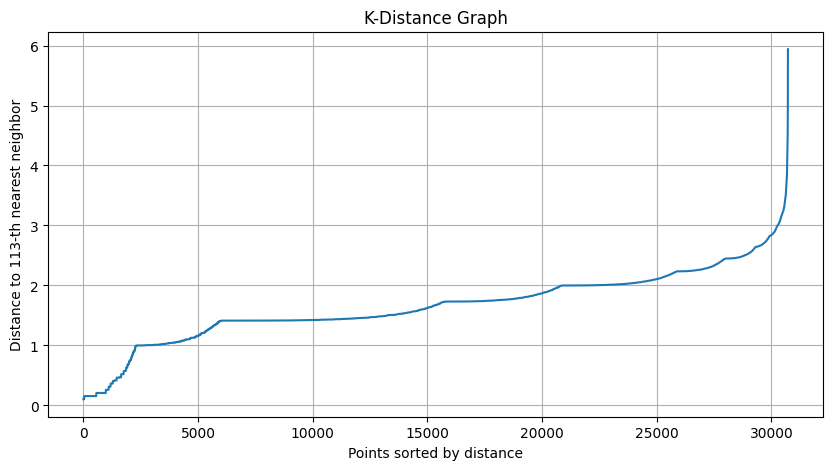

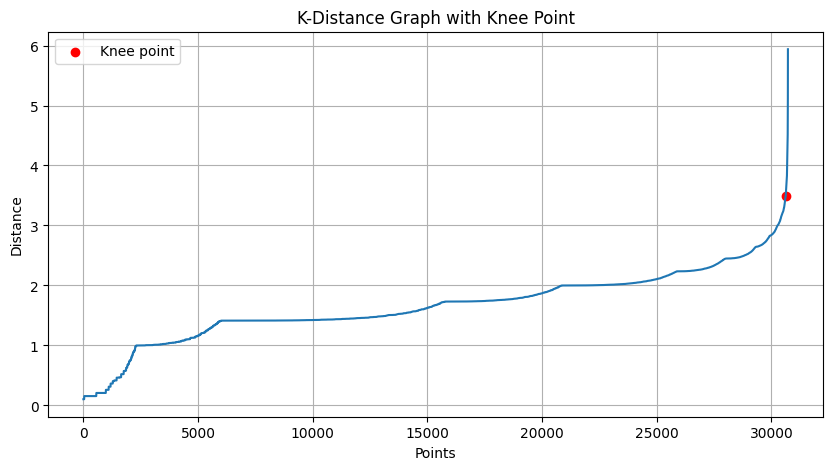

3.48401045136746
eps: 2.787208361093968, min_pts: 4, clusters: 5
Eps: 2.787, MinPts: 4, Score: 0.378
eps: 2.787208361093968, min_pts: 6, clusters: 4
Eps: 2.787, MinPts: 6, Score: 0.384
eps: 3.135609406230714, min_pts: 4, clusters: 4
Eps: 3.136, MinPts: 4, Score: 0.384
eps: 3.135609406230714, min_pts: 6, clusters: 4
Eps: 3.136, MinPts: 6, Score: 0.383
eps: 3.4840104513674603, min_pts: 4, clusters: 4
Eps: 3.484, MinPts: 4, Score: 0.382
eps: 3.4840104513674603, min_pts: 6, clusters: 4
Eps: 3.484, MinPts: 6, Score: 0.382
eps: 3.832411496504206, min_pts: 4, clusters: 3
Eps: 3.832, MinPts: 4, Score: 0.544
eps: 3.832411496504206, min_pts: 6, clusters: 3
Eps: 3.832, MinPts: 6, Score: 0.544
eps: 4.180812541640952, min_pts: 4, clusters: 3
Eps: 4.181, MinPts: 4, Score: 0.546
eps: 4.180812541640952, min_pts: 6, clusters: 3
Eps: 4.181, MinPts: 6, Score: 0.546


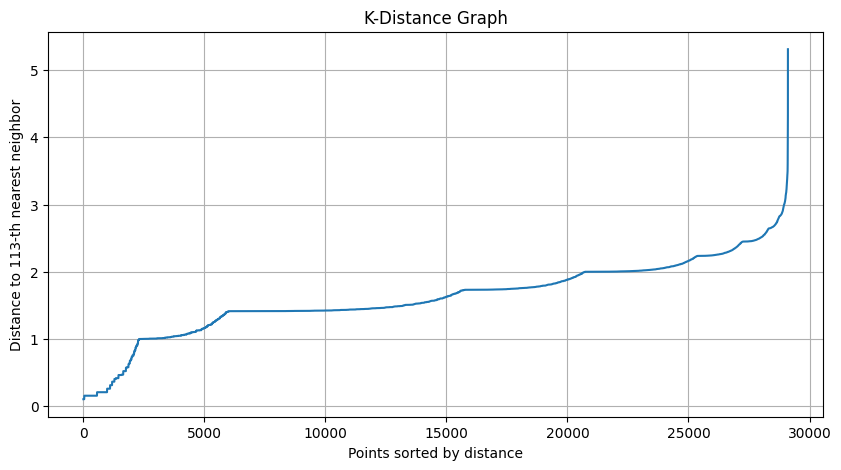

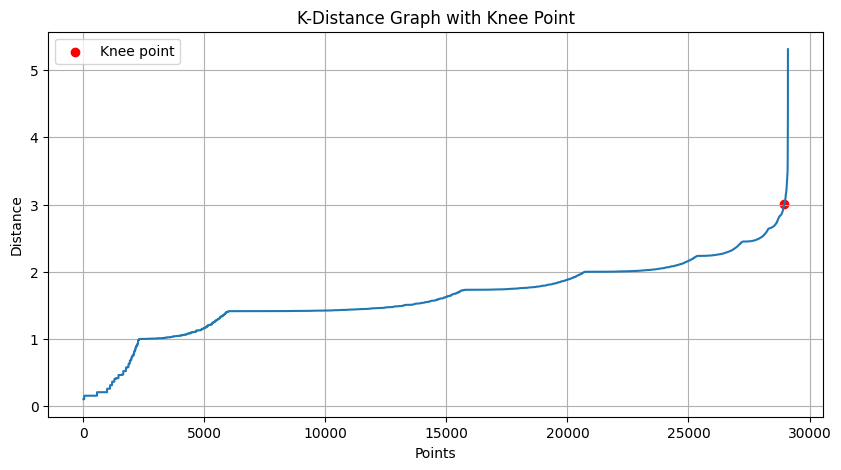

3.0098815953246136
eps: 2.407905276259691, min_pts: 4, clusters: 2
Eps: 2.408, MinPts: 4, Score: 0.368
eps: 2.407905276259691, min_pts: 6, clusters: 2
Eps: 2.408, MinPts: 6, Score: 0.368
eps: 2.7088934357921524, min_pts: 4, clusters: 2
Eps: 2.709, MinPts: 4, Score: 0.372
eps: 2.7088934357921524, min_pts: 6, clusters: 2
Eps: 2.709, MinPts: 6, Score: 0.372
eps: 3.0098815953246136, min_pts: 4, clusters: 2
Eps: 3.010, MinPts: 4, Score: 0.374
eps: 3.0098815953246136, min_pts: 6, clusters: 2
Eps: 3.010, MinPts: 6, Score: 0.374
eps: 3.310869754857075, min_pts: 4, clusters: 2
Eps: 3.311, MinPts: 4, Score: 0.374
eps: 3.310869754857075, min_pts: 6, clusters: 2
Eps: 3.311, MinPts: 6, Score: 0.374
eps: 3.611857914389536, min_pts: 4, clusters: 1
eps: 3.611857914389536, min_pts: 6, clusters: 1


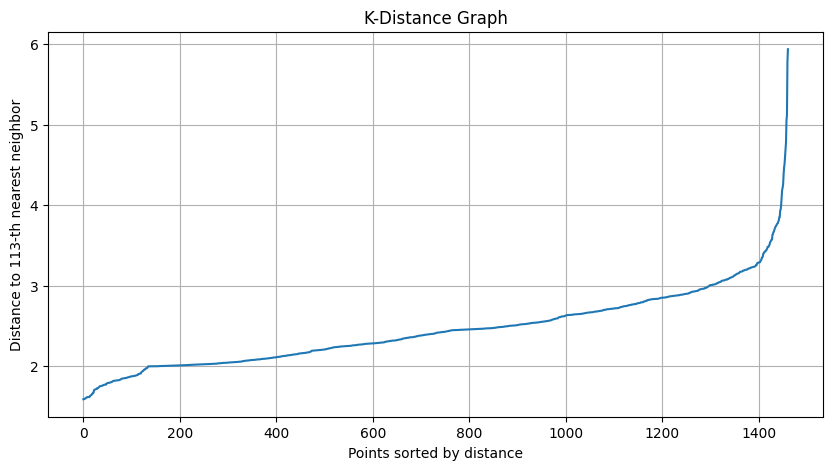

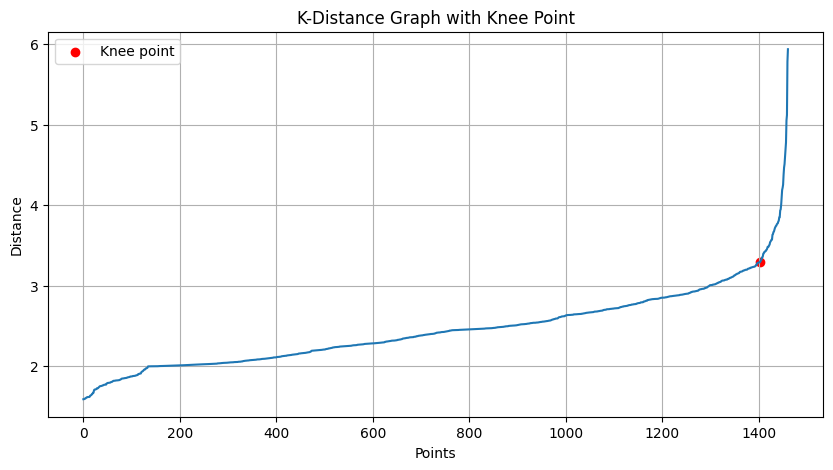

3.292972990405132
eps: 2.6343783923241055, min_pts: 4, clusters: 2
Eps: 2.634, MinPts: 4, Score: 0.347
eps: 2.6343783923241055, min_pts: 6, clusters: 1
eps: 2.9636756913646187, min_pts: 4, clusters: 1
eps: 2.9636756913646187, min_pts: 6, clusters: 1
eps: 3.292972990405132, min_pts: 4, clusters: 1
eps: 3.292972990405132, min_pts: 6, clusters: 1
eps: 3.622270289445645, min_pts: 4, clusters: 1
eps: 3.622270289445645, min_pts: 6, clusters: 1
eps: 3.9515675884861583, min_pts: 4, clusters: 1
eps: 3.9515675884861583, min_pts: 6, clusters: 1
Skipping further split for cluster 1 due to small sub-cluster sizes.


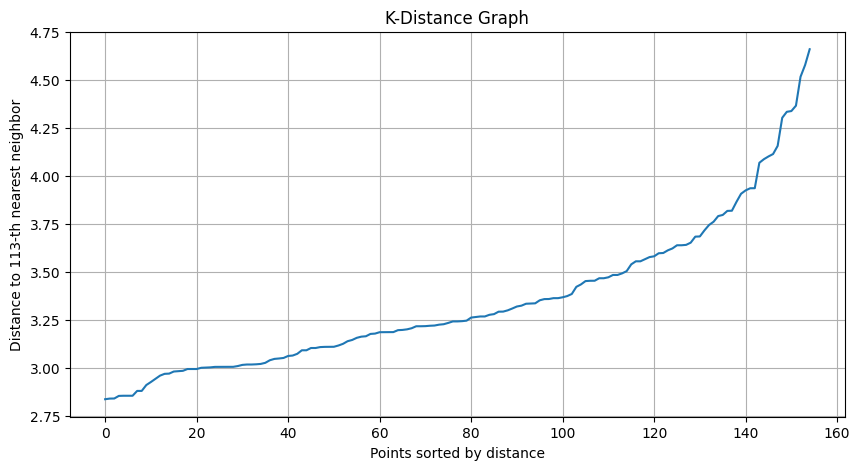

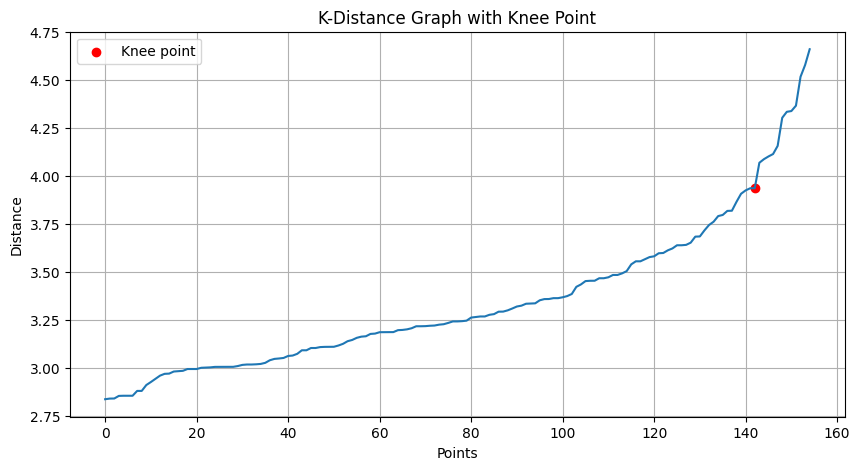

3.9363519024092923
eps: 3.149081521927434, min_pts: 4, clusters: 1
eps: 3.149081521927434, min_pts: 6, clusters: 1
eps: 3.542716712168363, min_pts: 4, clusters: 1
eps: 3.542716712168363, min_pts: 6, clusters: 1
eps: 3.9363519024092923, min_pts: 4, clusters: 1
eps: 3.9363519024092923, min_pts: 6, clusters: 1
eps: 4.329987092650221, min_pts: 4, clusters: 1
eps: 4.329987092650221, min_pts: 6, clusters: 1
eps: 4.72362228289115, min_pts: 4, clusters: 1
eps: 4.72362228289115, min_pts: 6, clusters: 1


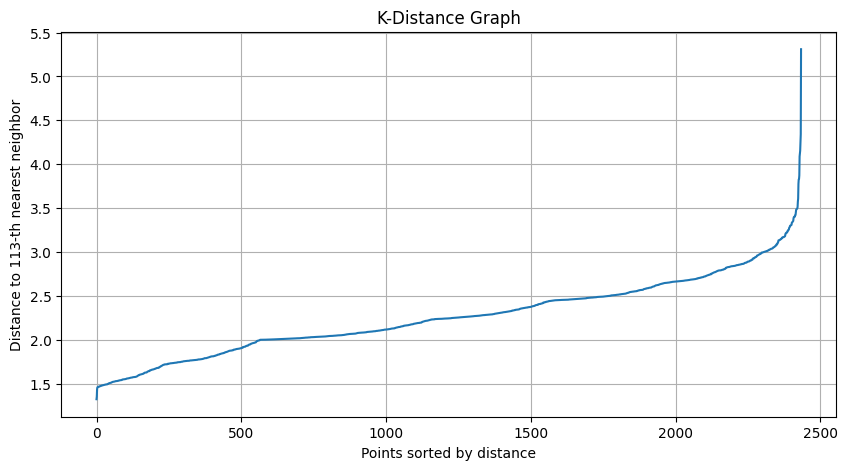

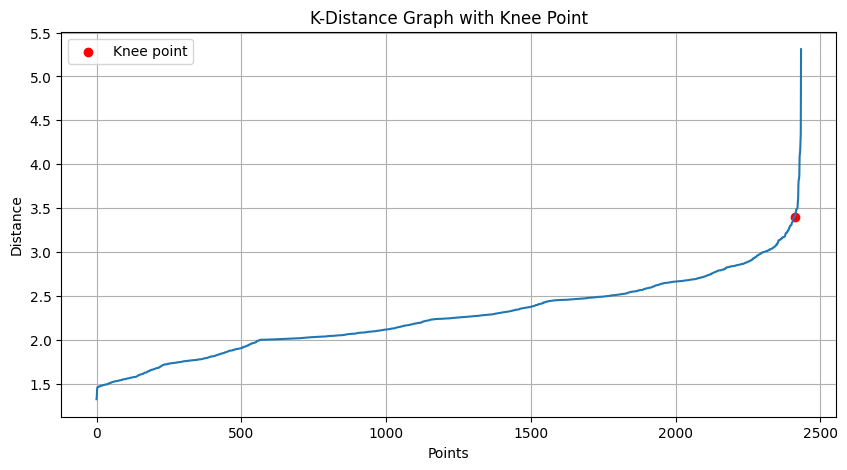

3.4005077026323676
eps: 2.720406162105894, min_pts: 4, clusters: 1
eps: 2.720406162105894, min_pts: 6, clusters: 1
eps: 3.0604569323691306, min_pts: 4, clusters: 1
eps: 3.0604569323691306, min_pts: 6, clusters: 1
eps: 3.4005077026323676, min_pts: 4, clusters: 1
eps: 3.4005077026323676, min_pts: 6, clusters: 1
eps: 3.740558472895604, min_pts: 4, clusters: 1
eps: 3.740558472895604, min_pts: 6, clusters: 1
eps: 4.0806092431588405, min_pts: 4, clusters: 1
eps: 4.0806092431588405, min_pts: 6, clusters: 1


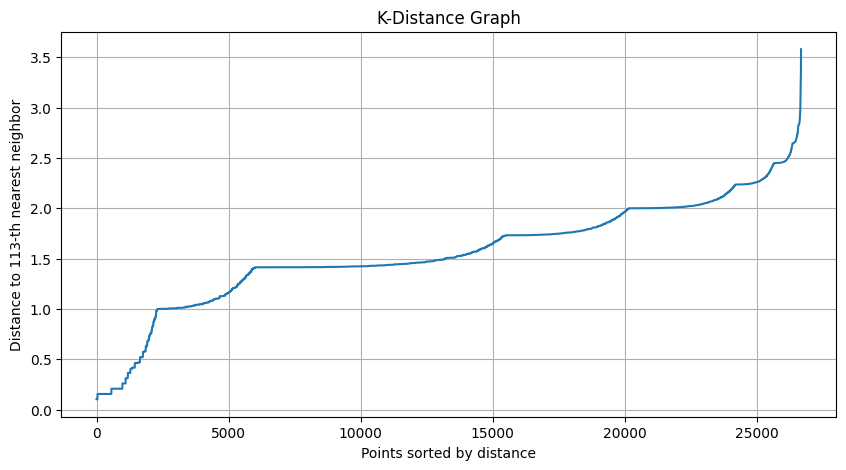

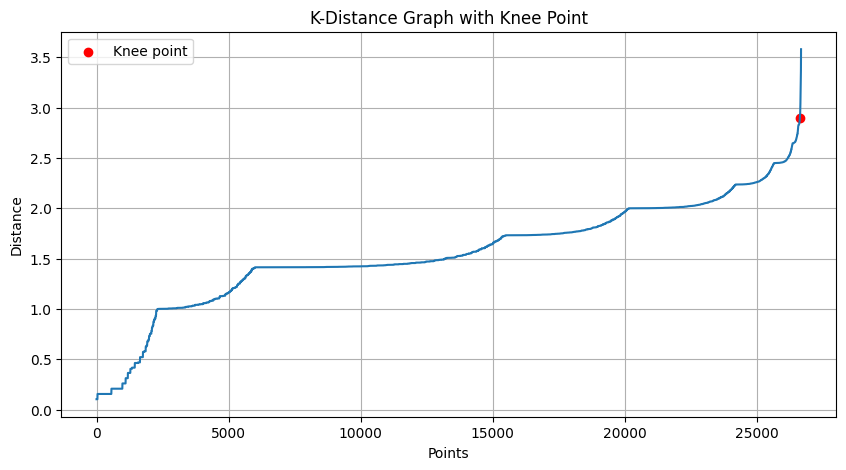

2.8919098425901657
eps: 2.3135278740721326, min_pts: 4, clusters: 1
eps: 2.3135278740721326, min_pts: 6, clusters: 1
eps: 2.602718858331149, min_pts: 4, clusters: 1
eps: 2.602718858331149, min_pts: 6, clusters: 1
eps: 2.8919098425901657, min_pts: 4, clusters: 1
eps: 2.8919098425901657, min_pts: 6, clusters: 1
eps: 3.1811008268491823, min_pts: 4, clusters: 1
eps: 3.1811008268491823, min_pts: 6, clusters: 1
eps: 3.470291811108199, min_pts: 4, clusters: 1
eps: 3.470291811108199, min_pts: 6, clusters: 1
Silhouette Score after Recursive DBSCAN refinement: 0.38447703542276895


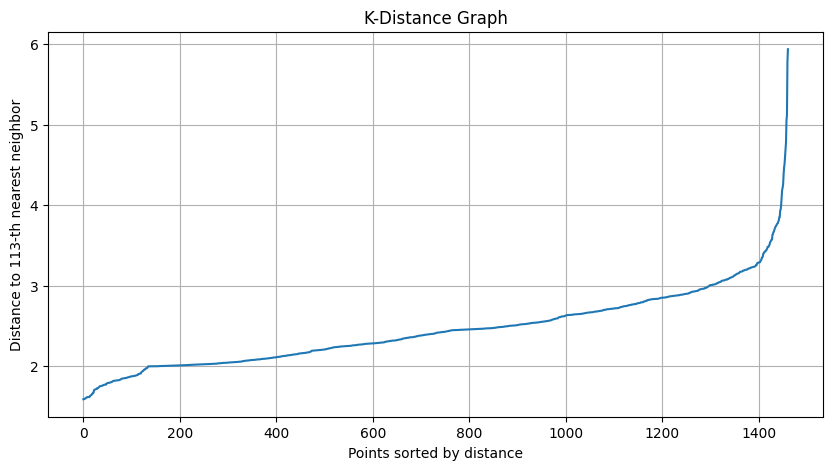

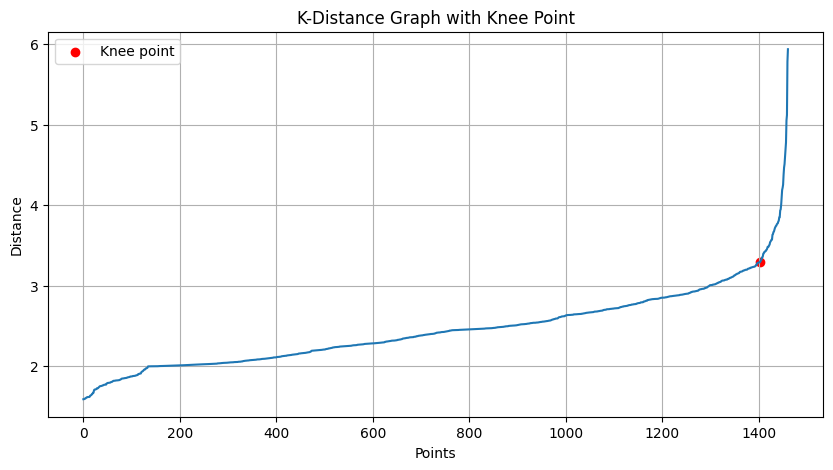

3.292972990405132
eps: 2.6343783923241055, min_pts: 4, clusters: 2
Eps: 2.634, MinPts: 4, Score: 0.347
eps: 2.6343783923241055, min_pts: 6, clusters: 1
eps: 2.9636756913646187, min_pts: 4, clusters: 1
eps: 2.9636756913646187, min_pts: 6, clusters: 1
eps: 3.292972990405132, min_pts: 4, clusters: 1
eps: 3.292972990405132, min_pts: 6, clusters: 1
eps: 3.622270289445645, min_pts: 4, clusters: 1
eps: 3.622270289445645, min_pts: 6, clusters: 1
eps: 3.9515675884861583, min_pts: 4, clusters: 1
eps: 3.9515675884861583, min_pts: 6, clusters: 1
Skipping further split for cluster 1 due to small sub-cluster sizes.


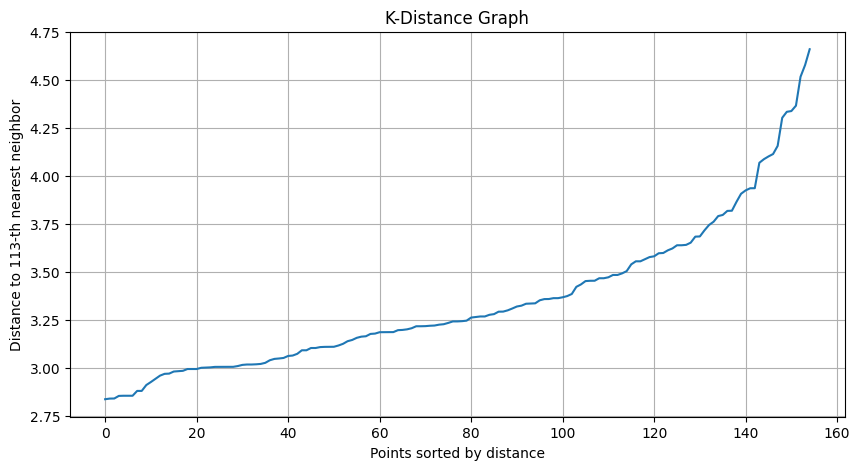

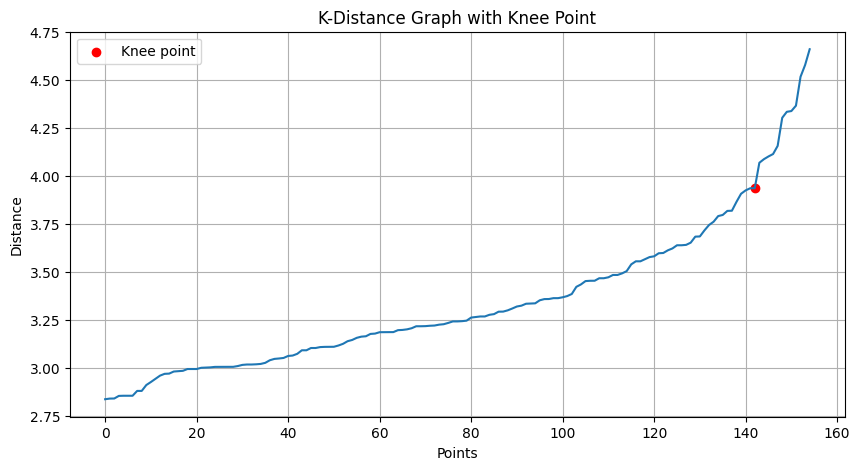

3.9363519024092923
eps: 3.149081521927434, min_pts: 4, clusters: 1
eps: 3.149081521927434, min_pts: 6, clusters: 1
eps: 3.542716712168363, min_pts: 4, clusters: 1
eps: 3.542716712168363, min_pts: 6, clusters: 1
eps: 3.9363519024092923, min_pts: 4, clusters: 1
eps: 3.9363519024092923, min_pts: 6, clusters: 1
eps: 4.329987092650221, min_pts: 4, clusters: 1
eps: 4.329987092650221, min_pts: 6, clusters: 1
eps: 4.72362228289115, min_pts: 4, clusters: 1
eps: 4.72362228289115, min_pts: 6, clusters: 1
Silhouette Score after Recursive DBSCAN refinement: 0.38447703542276895


/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_81762/936715042.py:10: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_val, p_val = f_oneway(*groups)


Processing cluster 3 with 2434 transactions
Adjusted thresholds for cluster 3: support=0.02629416598192276, confidence=0.4125, lift=1.794985250737463
Processing cluster 4 with 26675 transactions
Adjusted thresholds for cluster 4: support=0.02500468603561387, confidence=0.39268344989667037, lift=1.7402947339840715
Processing cluster 1 with 1461 transactions
Adjusted thresholds for cluster 1: support=0.026009582477754964, confidence=0.4146341463414634, lift=1.970268521449206
Processing cluster 2 with 155 transactions
Adjusted thresholds for cluster 2: support=0.03225806451612903, confidence=0.6666666666666666, lift=3.2291666666666665
Generated 107 rules for cluster 3 with relaxed thresholds: {'min_support': 0.02629416598192276, 'min_confidence': 0.4125, 'min_lift': 1.794985250737463, 'max_items': 3}
Generated 84 rules for cluster 4 with relaxed thresholds: {'min_support': 0.02500468603561387, 'min_confidence': 0.39268344989667037, 'min_lift': 1.7402947339840715, 'max_items': 3}
Generated

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


DATA RULES CLUSTER:  {3:                                              antecedents  \
3383                      (marital-status_Never-married)   
3384                        (relationship_Not-in-family)   
3391   (native_country_aggregated_United-States, mari...   
3392   (native_country_aggregated_United-States, rela...   
3394                      (marital-status_Never-married)   
...                                                  ...   
18873                            (education_Prof-school)   
18875                  (sex_Male, education_Prof-school)   
18876                            (education_Prof-school)   
18891  (education_Prof-school, marital-status_Married...   
18893                            (education_Prof-school)   

                                             consequents  antecedent support  \
3383                        (relationship_Not-in-family)            0.173377   
3384                      (marital-status_Never-married)            0.202958   
3391          

In [172]:
execute_pipeline(adult_df, 'income', 'adult_pipeline_results')

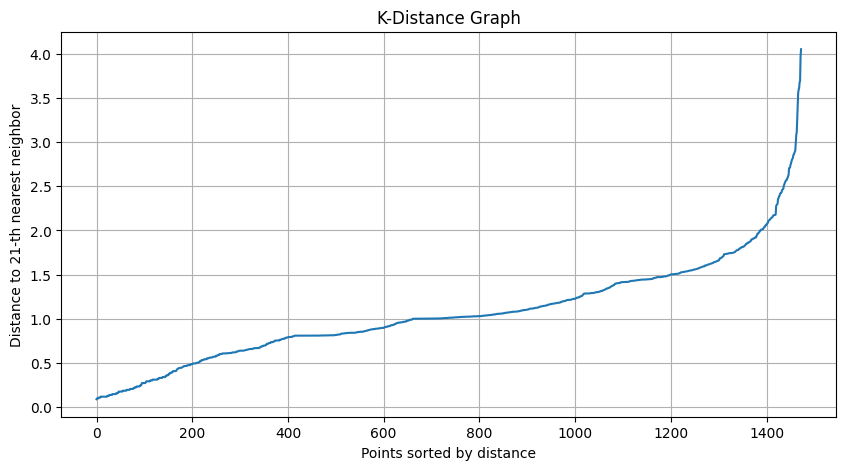

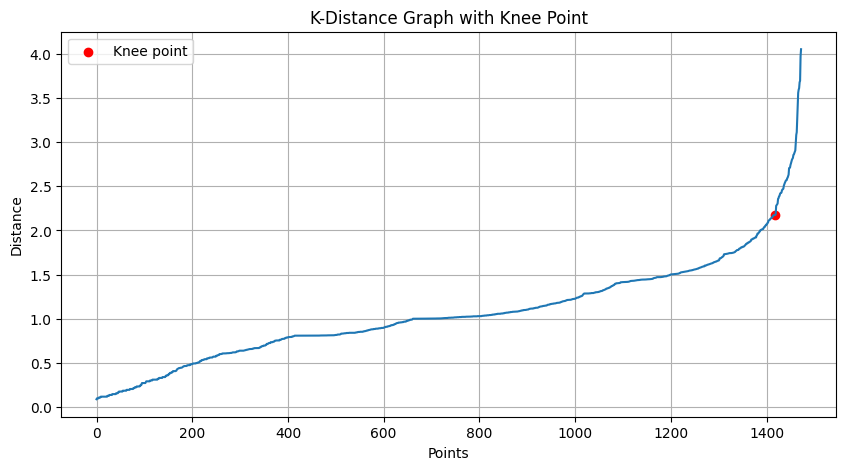

2.1757900890587334
eps: 1.7406320712469867, min_pts: 4, clusters: 6
Eps: 1.741, MinPts: 4, Score: 0.320
eps: 1.7406320712469867, min_pts: 6, clusters: 6
Eps: 1.741, MinPts: 6, Score: 0.319
eps: 1.95821108015286, min_pts: 4, clusters: 6
Eps: 1.958, MinPts: 4, Score: 0.320
eps: 1.95821108015286, min_pts: 6, clusters: 6
Eps: 1.958, MinPts: 6, Score: 0.319
eps: 2.1757900890587334, min_pts: 4, clusters: 7
Eps: 2.176, MinPts: 4, Score: 0.323
eps: 2.1757900890587334, min_pts: 6, clusters: 6
Eps: 2.176, MinPts: 6, Score: 0.323
eps: 2.393369097964607, min_pts: 4, clusters: 4
Eps: 2.393, MinPts: 4, Score: 0.329
eps: 2.393369097964607, min_pts: 6, clusters: 3
Eps: 2.393, MinPts: 6, Score: 0.333
eps: 2.61094810687048, min_pts: 4, clusters: 4
Eps: 2.611, MinPts: 4, Score: 0.328
eps: 2.61094810687048, min_pts: 6, clusters: 4
Eps: 2.611, MinPts: 6, Score: 0.330


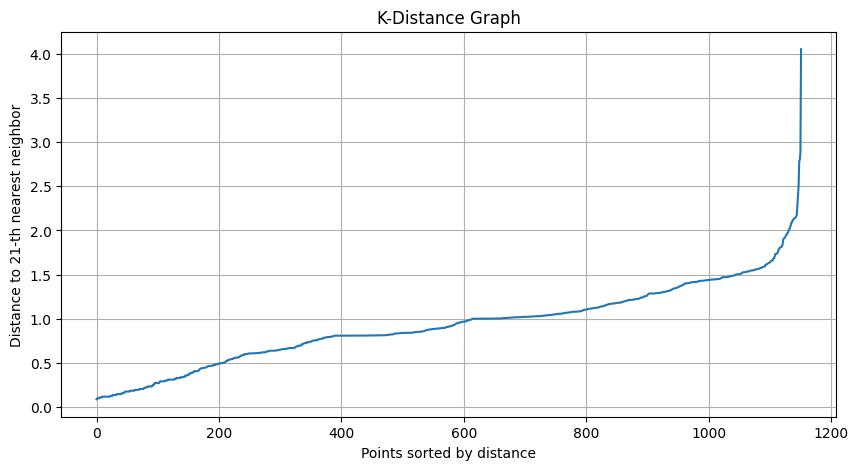

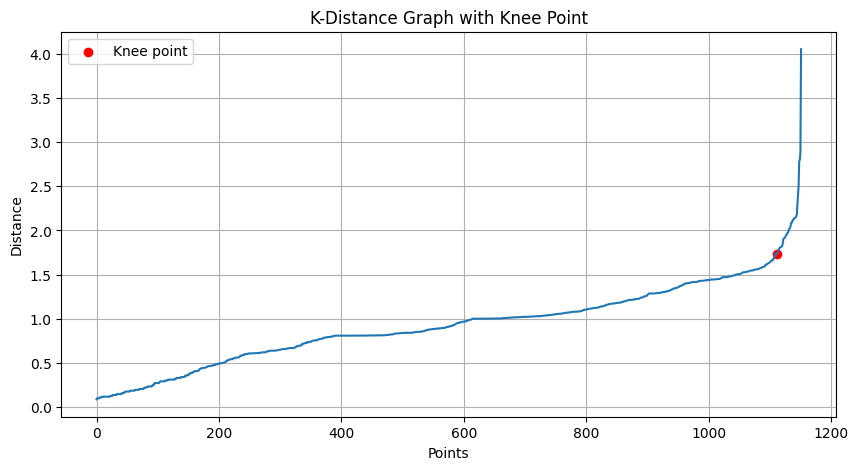

1.7347390218107461
eps: 1.387791217448597, min_pts: 4, clusters: 2
Eps: 1.388, MinPts: 4, Score: 0.300
eps: 1.387791217448597, min_pts: 6, clusters: 2
Eps: 1.388, MinPts: 6, Score: 0.299
eps: 1.5612651196296716, min_pts: 4, clusters: 2
Eps: 1.561, MinPts: 4, Score: 0.293
eps: 1.5612651196296716, min_pts: 6, clusters: 2
Eps: 1.561, MinPts: 6, Score: 0.302
eps: 1.7347390218107461, min_pts: 4, clusters: 2
Eps: 1.735, MinPts: 4, Score: 0.295
eps: 1.7347390218107461, min_pts: 6, clusters: 2
Eps: 1.735, MinPts: 6, Score: 0.295
eps: 1.9082129239918206, min_pts: 4, clusters: 2
Eps: 1.908, MinPts: 4, Score: 0.295
eps: 1.9082129239918206, min_pts: 6, clusters: 2
Eps: 1.908, MinPts: 6, Score: 0.295
eps: 2.0816868261728954, min_pts: 4, clusters: 2
Eps: 2.082, MinPts: 4, Score: 0.294
eps: 2.0816868261728954, min_pts: 6, clusters: 2
Eps: 2.082, MinPts: 6, Score: 0.294


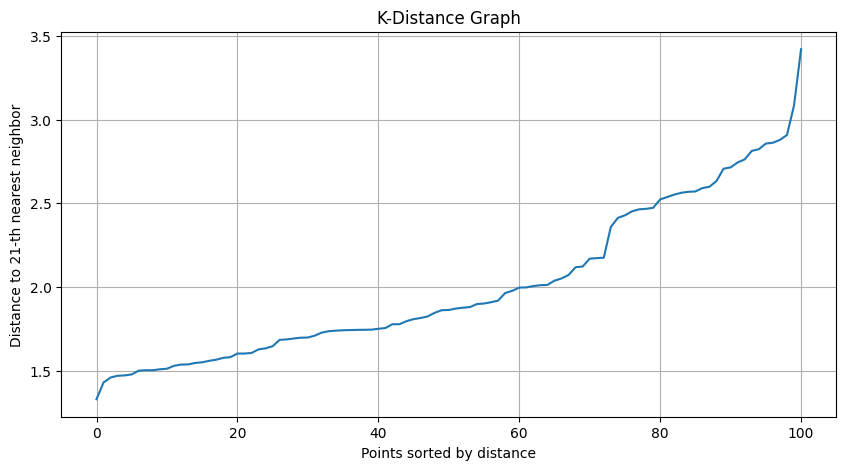

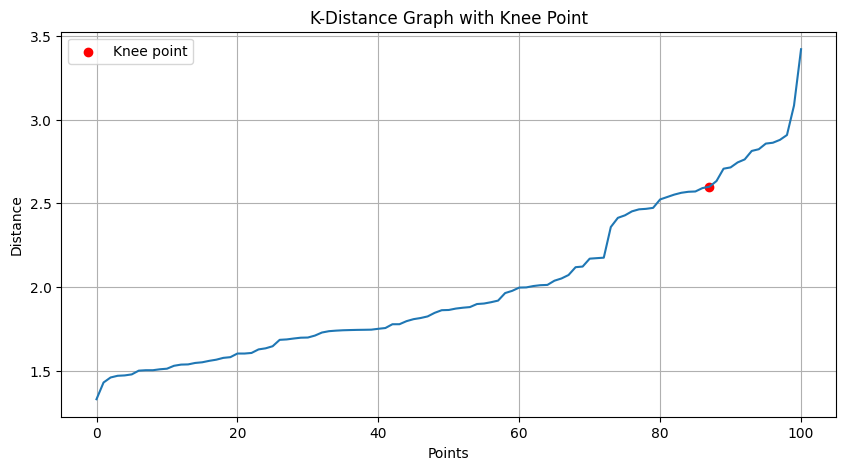

2.5991767853392065
eps: 2.0793414282713654, min_pts: 4, clusters: 2
Eps: 2.079, MinPts: 4, Score: 0.303
eps: 2.0793414282713654, min_pts: 6, clusters: 2
Eps: 2.079, MinPts: 6, Score: 0.262
eps: 2.3392591068052857, min_pts: 4, clusters: 1
eps: 2.3392591068052857, min_pts: 6, clusters: 1
eps: 2.5991767853392065, min_pts: 4, clusters: 1
eps: 2.5991767853392065, min_pts: 6, clusters: 1
eps: 2.8590944638731273, min_pts: 4, clusters: 1
eps: 2.8590944638731273, min_pts: 6, clusters: 1
eps: 3.1190121424070476, min_pts: 4, clusters: 1
eps: 3.1190121424070476, min_pts: 6, clusters: 1
Skipping further split for cluster 1 due to small sub-cluster sizes.


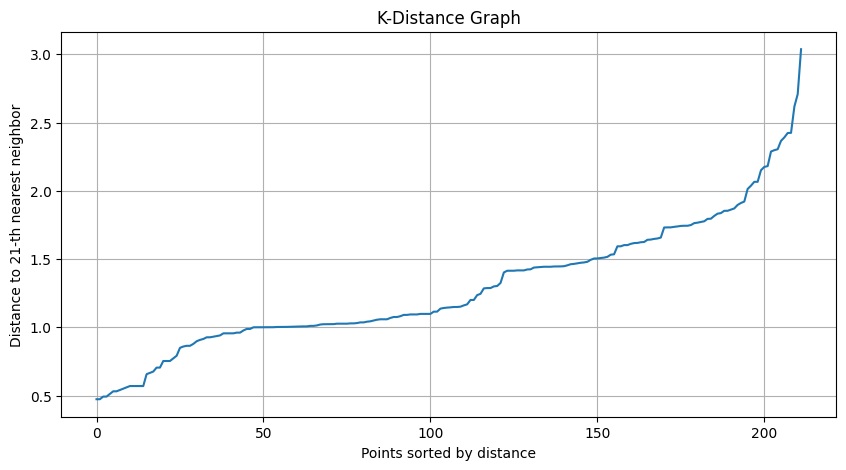

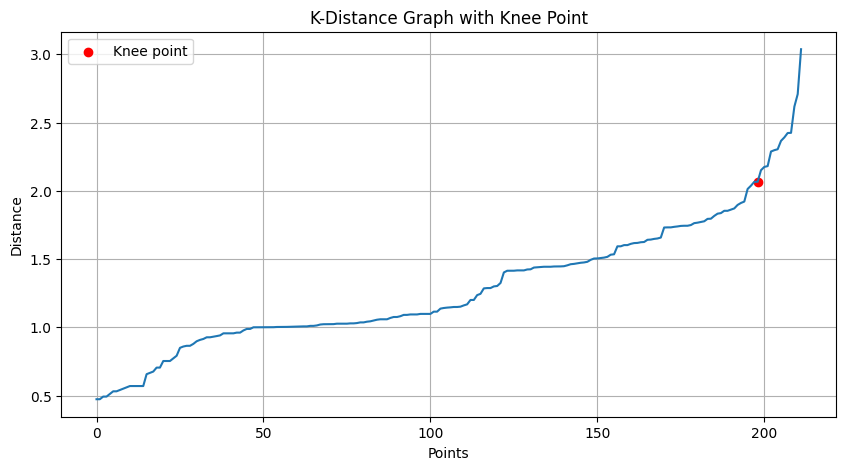

2.0659008248699586
eps: 1.652720659895967, min_pts: 4, clusters: 2
Eps: 1.653, MinPts: 4, Score: 0.363
eps: 1.652720659895967, min_pts: 6, clusters: 2
Eps: 1.653, MinPts: 6, Score: 0.363
eps: 1.8593107423829627, min_pts: 4, clusters: 2
Eps: 1.859, MinPts: 4, Score: 0.397
eps: 1.8593107423829627, min_pts: 6, clusters: 2
Eps: 1.859, MinPts: 6, Score: 0.397
eps: 2.0659008248699586, min_pts: 4, clusters: 2
Eps: 2.066, MinPts: 4, Score: 0.397
eps: 2.0659008248699586, min_pts: 6, clusters: 2
Eps: 2.066, MinPts: 6, Score: 0.397
eps: 2.2724909073569544, min_pts: 4, clusters: 2
Eps: 2.272, MinPts: 4, Score: 0.397
eps: 2.2724909073569544, min_pts: 6, clusters: 2
Eps: 2.272, MinPts: 6, Score: 0.397
eps: 2.47908098984395, min_pts: 4, clusters: 1
eps: 2.47908098984395, min_pts: 6, clusters: 1


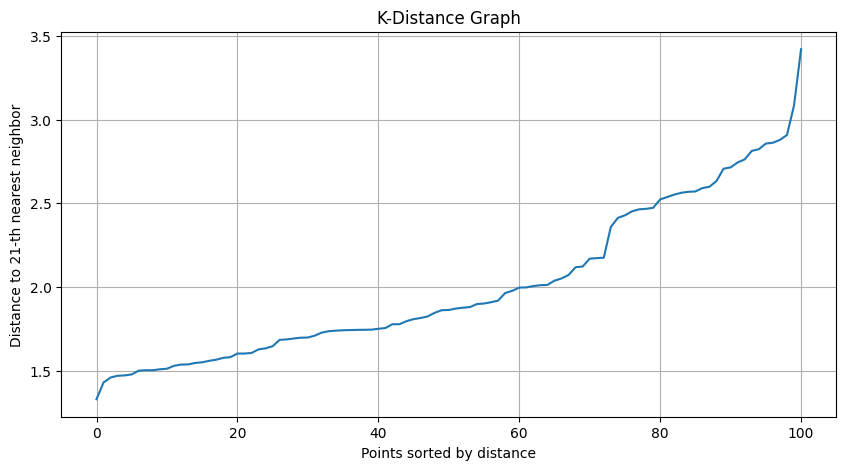

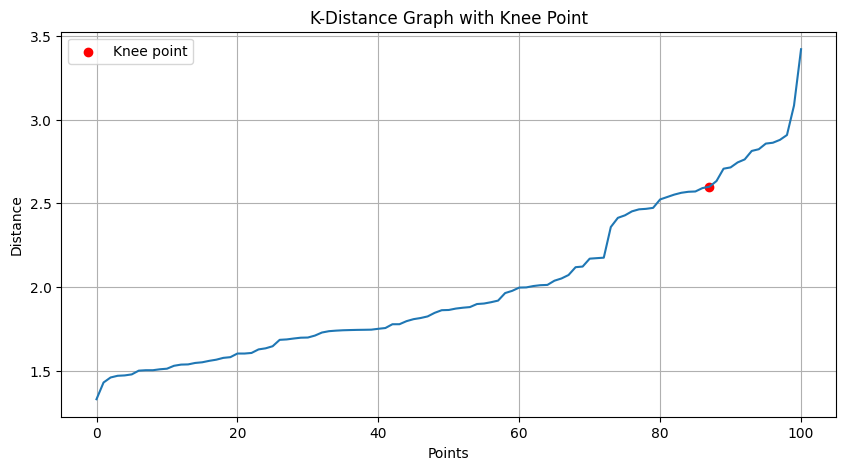

2.5991767853392065
eps: 2.0793414282713654, min_pts: 4, clusters: 2
Eps: 2.079, MinPts: 4, Score: 0.303
eps: 2.0793414282713654, min_pts: 6, clusters: 2
Eps: 2.079, MinPts: 6, Score: 0.262
eps: 2.3392591068052857, min_pts: 4, clusters: 1
eps: 2.3392591068052857, min_pts: 6, clusters: 1
eps: 2.5991767853392065, min_pts: 4, clusters: 1
eps: 2.5991767853392065, min_pts: 6, clusters: 1
eps: 2.8590944638731273, min_pts: 4, clusters: 1
eps: 2.8590944638731273, min_pts: 6, clusters: 1
eps: 3.1190121424070476, min_pts: 4, clusters: 1
eps: 3.1190121424070476, min_pts: 6, clusters: 1
Skipping further split for cluster 1 due to small sub-cluster sizes.


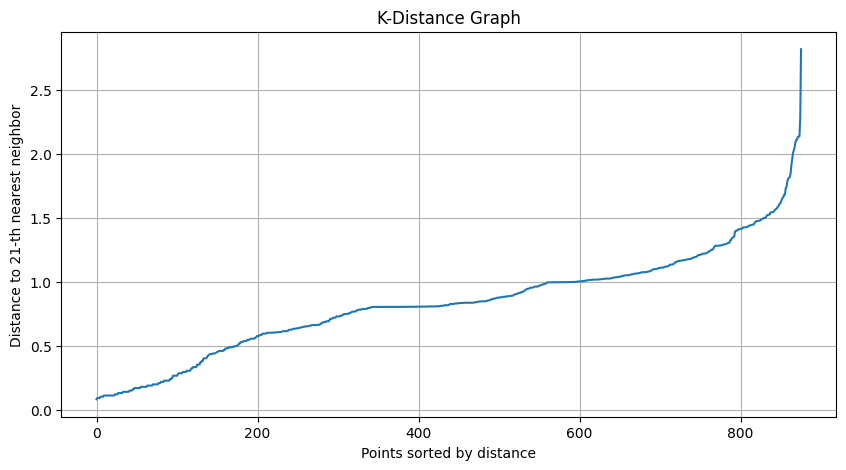

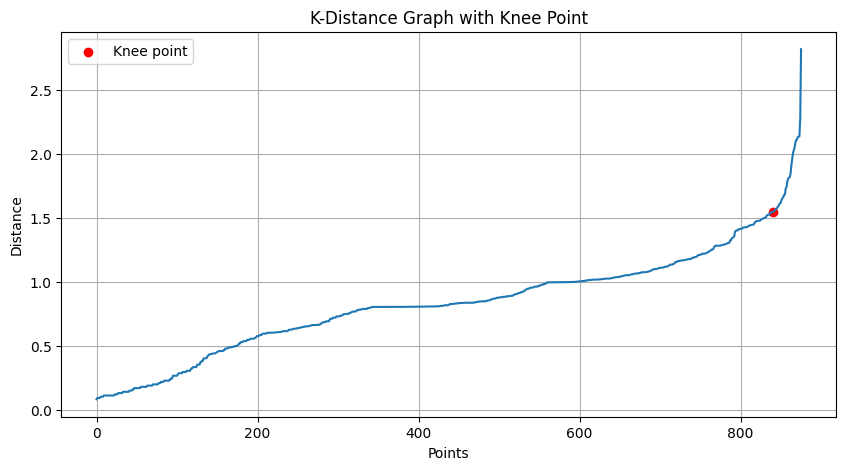

1.5481622539518456
eps: 1.2385298031614767, min_pts: 4, clusters: 1
eps: 1.2385298031614767, min_pts: 6, clusters: 1
eps: 1.3933460285566612, min_pts: 4, clusters: 1
eps: 1.3933460285566612, min_pts: 6, clusters: 1
eps: 1.5481622539518456, min_pts: 4, clusters: 1
eps: 1.5481622539518456, min_pts: 6, clusters: 1
eps: 1.70297847934703, min_pts: 4, clusters: 1
eps: 1.70297847934703, min_pts: 6, clusters: 1
eps: 1.8577947047422145, min_pts: 4, clusters: 1
eps: 1.8577947047422145, min_pts: 6, clusters: 1


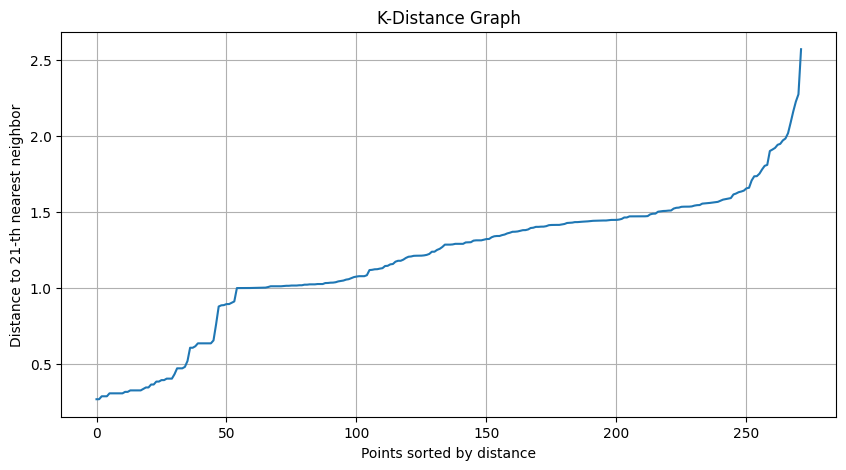

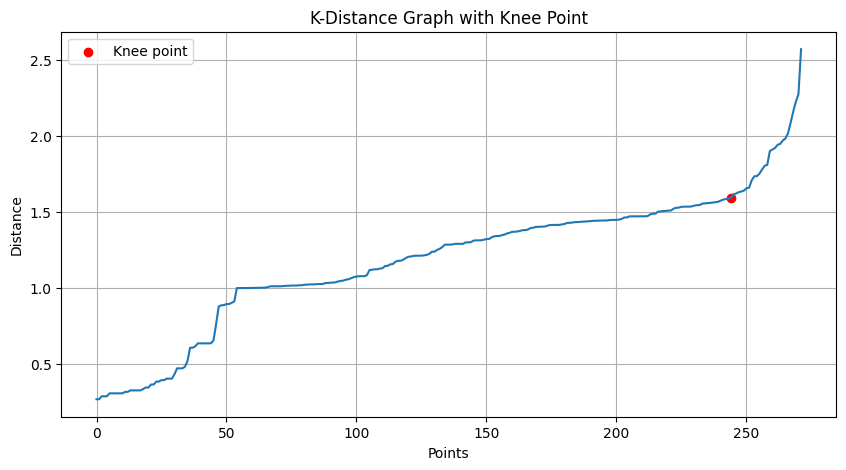

1.59091382141808
eps: 1.272731057134464, min_pts: 4, clusters: 2
Eps: 1.273, MinPts: 4, Score: 0.073
eps: 1.272731057134464, min_pts: 6, clusters: 1
eps: 1.4318224392762722, min_pts: 4, clusters: 1
eps: 1.4318224392762722, min_pts: 6, clusters: 1
eps: 1.59091382141808, min_pts: 4, clusters: 1
eps: 1.59091382141808, min_pts: 6, clusters: 1
eps: 1.7500052035598879, min_pts: 4, clusters: 1
eps: 1.7500052035598879, min_pts: 6, clusters: 1
eps: 1.909096585701696, min_pts: 4, clusters: 1
eps: 1.909096585701696, min_pts: 6, clusters: 1
Skipping further split for cluster 4 due to small sub-cluster sizes.


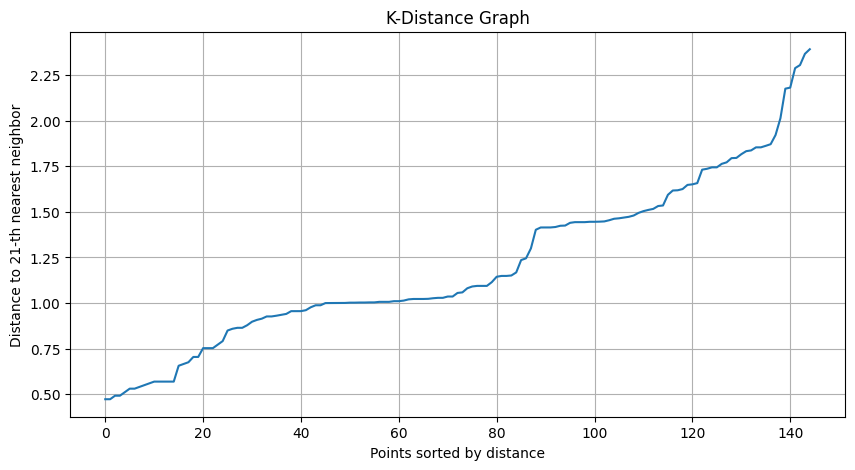

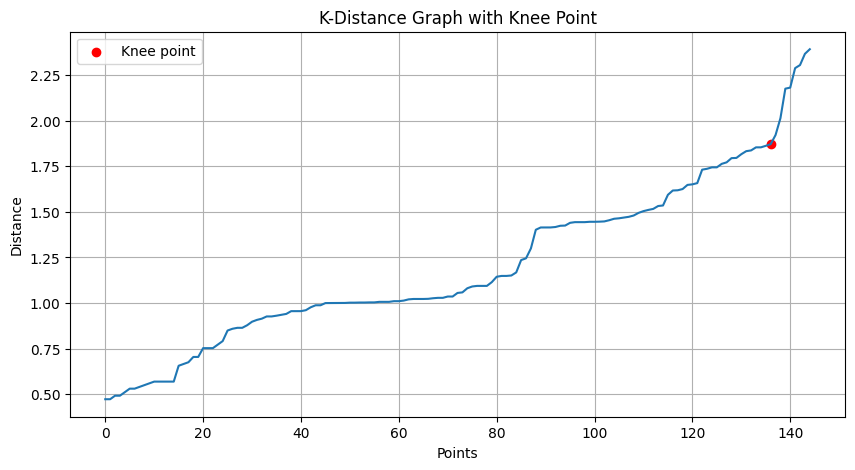

1.8708523133271056
eps: 1.4966818506616846, min_pts: 4, clusters: 1
eps: 1.4966818506616846, min_pts: 6, clusters: 1
eps: 1.683767081994395, min_pts: 4, clusters: 1
eps: 1.683767081994395, min_pts: 6, clusters: 1
eps: 1.8708523133271058, min_pts: 4, clusters: 1
eps: 1.8708523133271058, min_pts: 6, clusters: 1
eps: 2.0579375446598163, min_pts: 4, clusters: 1
eps: 2.0579375446598163, min_pts: 6, clusters: 1
eps: 2.2450227759925268, min_pts: 4, clusters: 1
eps: 2.2450227759925268, min_pts: 6, clusters: 1


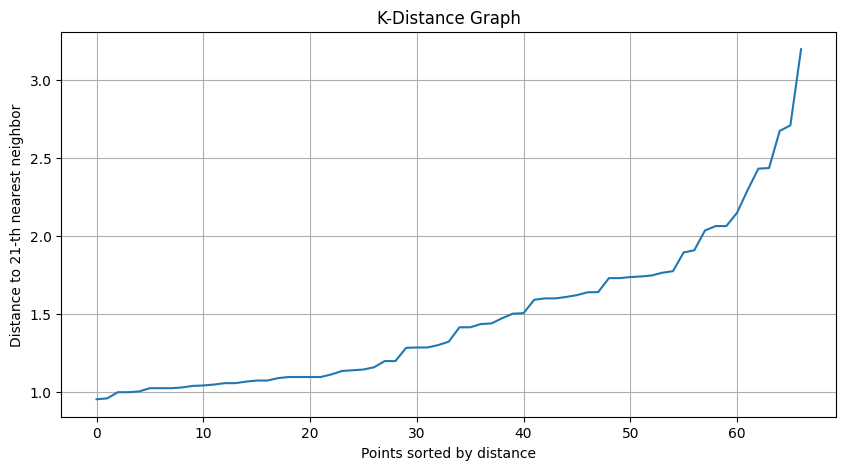

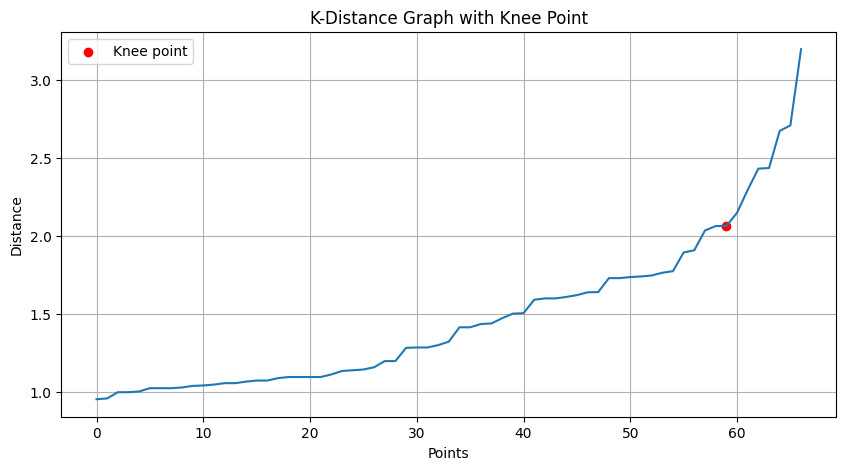

2.0659008248699586
eps: 1.652720659895967, min_pts: 4, clusters: 1
eps: 1.652720659895967, min_pts: 6, clusters: 1
eps: 1.8593107423829627, min_pts: 4, clusters: 1
eps: 1.8593107423829627, min_pts: 6, clusters: 1
eps: 2.0659008248699586, min_pts: 4, clusters: 1
eps: 2.0659008248699586, min_pts: 6, clusters: 1
eps: 2.2724909073569544, min_pts: 4, clusters: 1
eps: 2.2724909073569544, min_pts: 6, clusters: 1
eps: 2.47908098984395, min_pts: 4, clusters: 1
eps: 2.47908098984395, min_pts: 6, clusters: 1
Silhouette Score after Recursive DBSCAN refinement: 0.3283985031748593


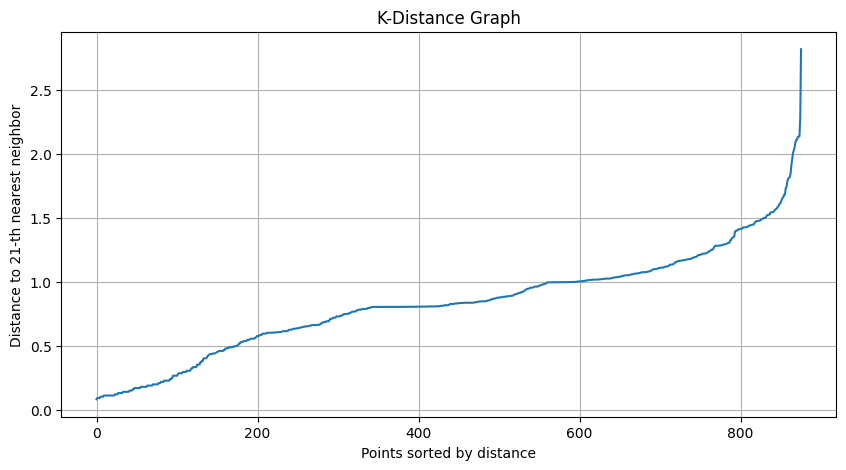

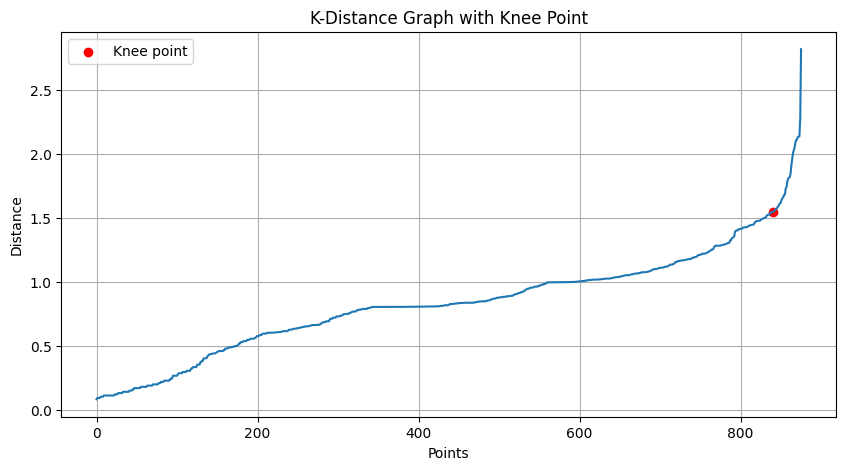

1.5481622539518456
eps: 1.2385298031614767, min_pts: 4, clusters: 1
eps: 1.2385298031614767, min_pts: 6, clusters: 1
eps: 1.3933460285566612, min_pts: 4, clusters: 1
eps: 1.3933460285566612, min_pts: 6, clusters: 1
eps: 1.5481622539518456, min_pts: 4, clusters: 1
eps: 1.5481622539518456, min_pts: 6, clusters: 1
eps: 1.70297847934703, min_pts: 4, clusters: 1
eps: 1.70297847934703, min_pts: 6, clusters: 1
eps: 1.8577947047422145, min_pts: 4, clusters: 1
eps: 1.8577947047422145, min_pts: 6, clusters: 1


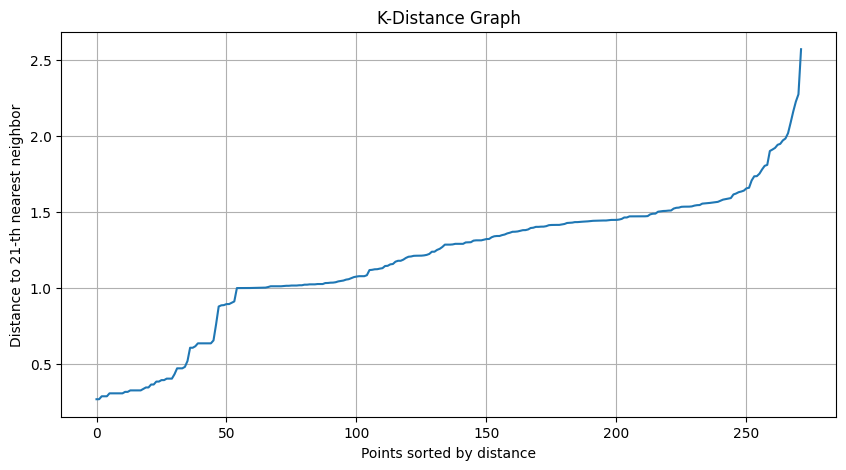

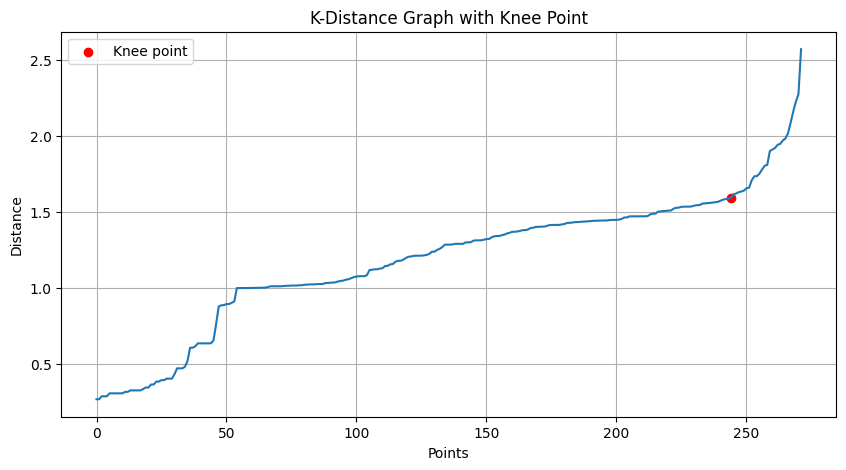

1.59091382141808
eps: 1.272731057134464, min_pts: 4, clusters: 2
Eps: 1.273, MinPts: 4, Score: 0.073
eps: 1.272731057134464, min_pts: 6, clusters: 1
eps: 1.4318224392762722, min_pts: 4, clusters: 1
eps: 1.4318224392762722, min_pts: 6, clusters: 1
eps: 1.59091382141808, min_pts: 4, clusters: 1
eps: 1.59091382141808, min_pts: 6, clusters: 1
eps: 1.7500052035598879, min_pts: 4, clusters: 1
eps: 1.7500052035598879, min_pts: 6, clusters: 1
eps: 1.909096585701696, min_pts: 4, clusters: 1
eps: 1.909096585701696, min_pts: 6, clusters: 1
Skipping further split for cluster 4 due to small sub-cluster sizes.
Silhouette Score after Recursive DBSCAN refinement: 0.3283985031748593


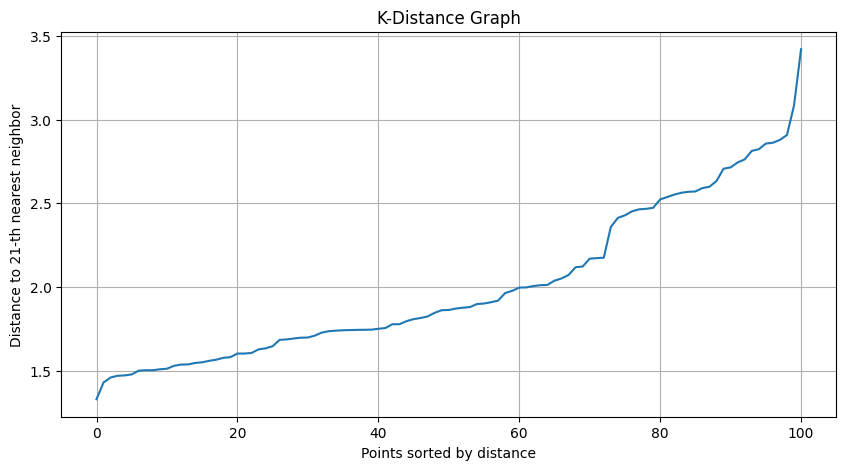

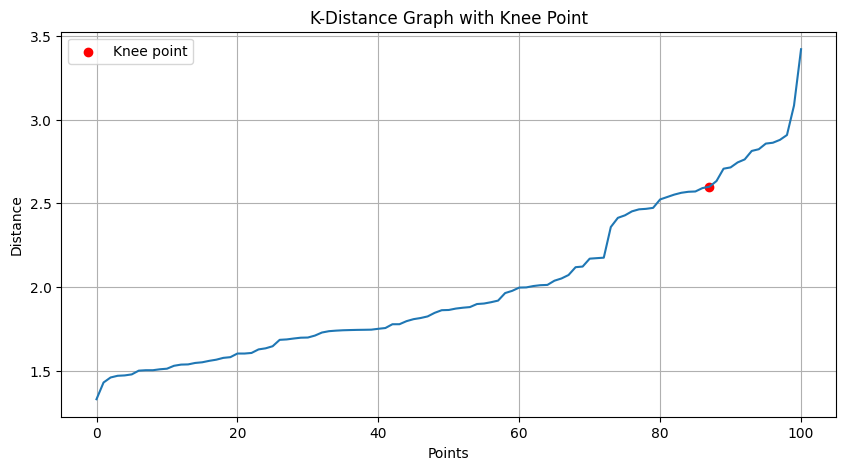

2.5991767853392065
eps: 2.0793414282713654, min_pts: 4, clusters: 2
Eps: 2.079, MinPts: 4, Score: 0.303
eps: 2.0793414282713654, min_pts: 6, clusters: 2
Eps: 2.079, MinPts: 6, Score: 0.262
eps: 2.3392591068052857, min_pts: 4, clusters: 1
eps: 2.3392591068052857, min_pts: 6, clusters: 1
eps: 2.5991767853392065, min_pts: 4, clusters: 1
eps: 2.5991767853392065, min_pts: 6, clusters: 1
eps: 2.8590944638731273, min_pts: 4, clusters: 1
eps: 2.8590944638731273, min_pts: 6, clusters: 1
eps: 3.1190121424070476, min_pts: 4, clusters: 1
eps: 3.1190121424070476, min_pts: 6, clusters: 1
Skipping further split for cluster 1 due to small sub-cluster sizes.


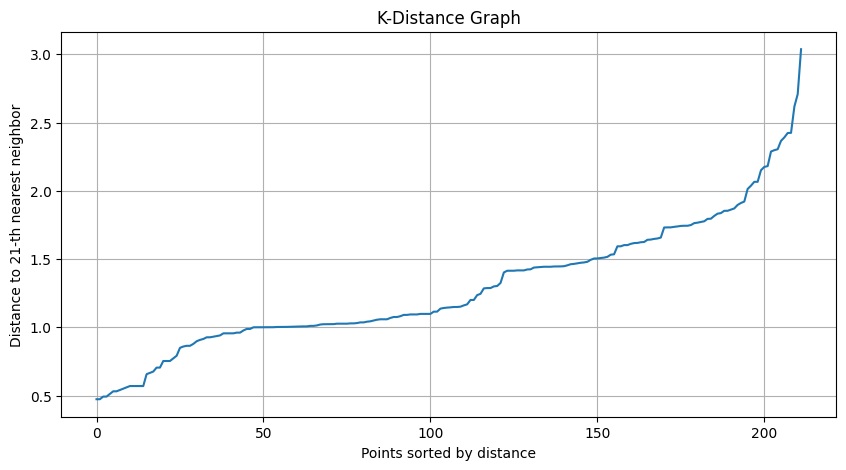

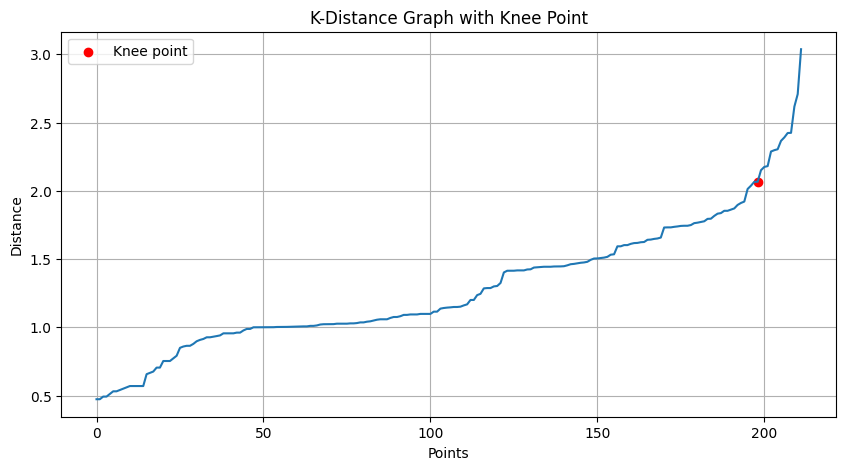

2.0659008248699586
eps: 1.652720659895967, min_pts: 4, clusters: 2
Eps: 1.653, MinPts: 4, Score: 0.363
eps: 1.652720659895967, min_pts: 6, clusters: 2
Eps: 1.653, MinPts: 6, Score: 0.363
eps: 1.8593107423829627, min_pts: 4, clusters: 2
Eps: 1.859, MinPts: 4, Score: 0.397
eps: 1.8593107423829627, min_pts: 6, clusters: 2
Eps: 1.859, MinPts: 6, Score: 0.397
eps: 2.0659008248699586, min_pts: 4, clusters: 2
Eps: 2.066, MinPts: 4, Score: 0.397
eps: 2.0659008248699586, min_pts: 6, clusters: 2
Eps: 2.066, MinPts: 6, Score: 0.397
eps: 2.2724909073569544, min_pts: 4, clusters: 2
Eps: 2.272, MinPts: 4, Score: 0.397
eps: 2.2724909073569544, min_pts: 6, clusters: 2
Eps: 2.272, MinPts: 6, Score: 0.397
eps: 2.47908098984395, min_pts: 4, clusters: 1
eps: 2.47908098984395, min_pts: 6, clusters: 1


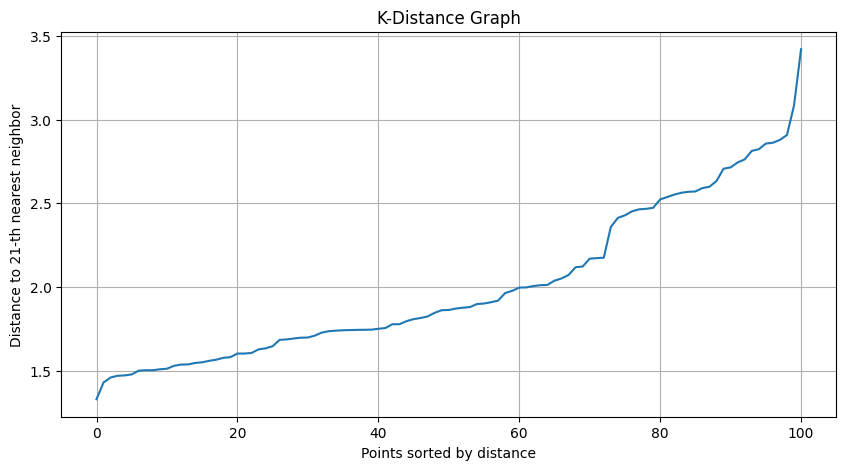

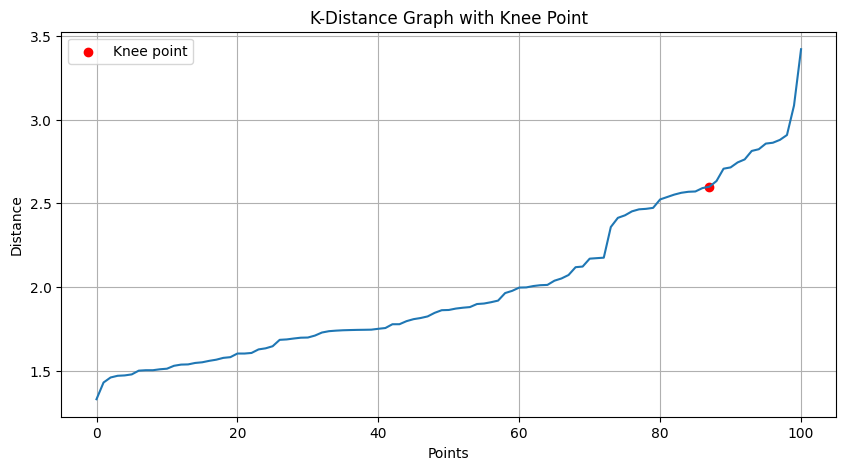

2.5991767853392065
eps: 2.0793414282713654, min_pts: 4, clusters: 2
Eps: 2.079, MinPts: 4, Score: 0.303
eps: 2.0793414282713654, min_pts: 6, clusters: 2
Eps: 2.079, MinPts: 6, Score: 0.262
eps: 2.3392591068052857, min_pts: 4, clusters: 1
eps: 2.3392591068052857, min_pts: 6, clusters: 1
eps: 2.5991767853392065, min_pts: 4, clusters: 1
eps: 2.5991767853392065, min_pts: 6, clusters: 1
eps: 2.8590944638731273, min_pts: 4, clusters: 1
eps: 2.8590944638731273, min_pts: 6, clusters: 1
eps: 3.1190121424070476, min_pts: 4, clusters: 1
eps: 3.1190121424070476, min_pts: 6, clusters: 1
Skipping further split for cluster 1 due to small sub-cluster sizes.


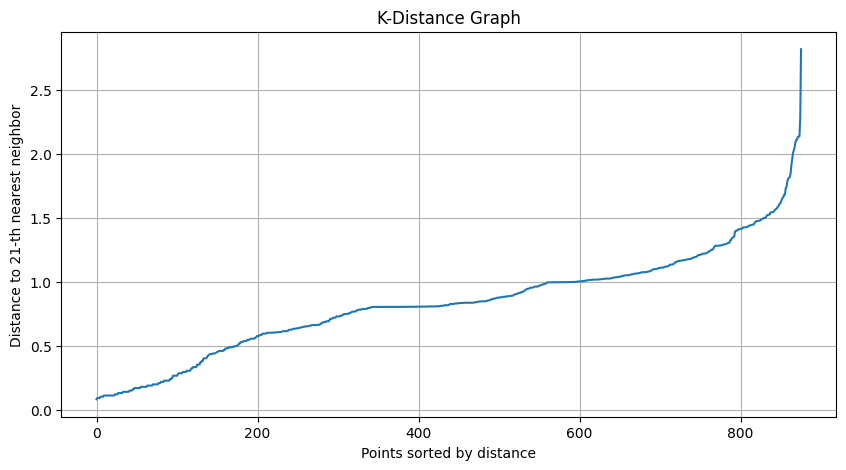

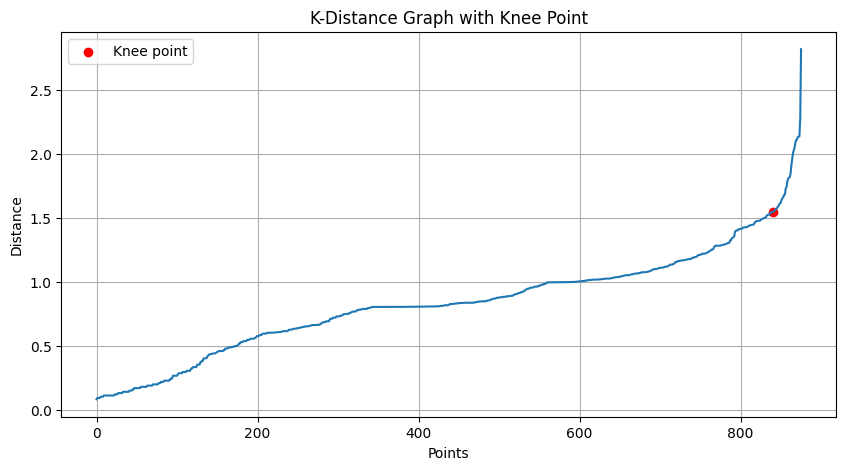

1.5481622539518456
eps: 1.2385298031614767, min_pts: 4, clusters: 1
eps: 1.2385298031614767, min_pts: 6, clusters: 1
eps: 1.3933460285566612, min_pts: 4, clusters: 1
eps: 1.3933460285566612, min_pts: 6, clusters: 1
eps: 1.5481622539518456, min_pts: 4, clusters: 1
eps: 1.5481622539518456, min_pts: 6, clusters: 1
eps: 1.70297847934703, min_pts: 4, clusters: 1
eps: 1.70297847934703, min_pts: 6, clusters: 1
eps: 1.8577947047422145, min_pts: 4, clusters: 1
eps: 1.8577947047422145, min_pts: 6, clusters: 1


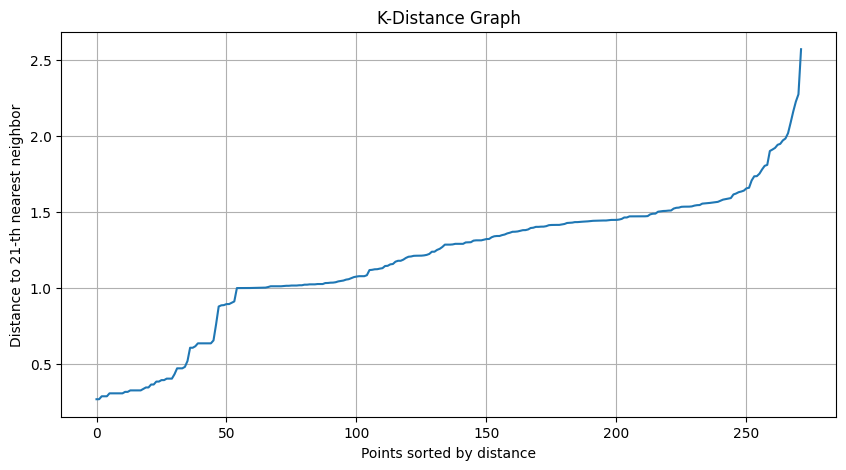

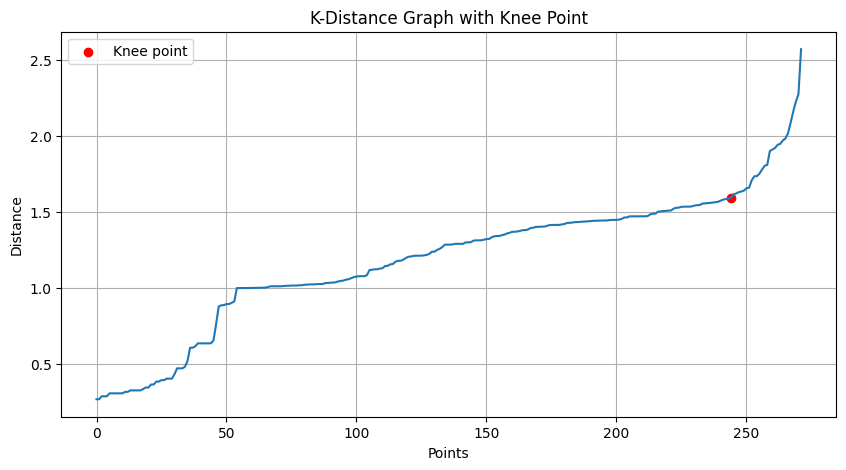

1.59091382141808
eps: 1.272731057134464, min_pts: 4, clusters: 2
Eps: 1.273, MinPts: 4, Score: 0.073
eps: 1.272731057134464, min_pts: 6, clusters: 1
eps: 1.4318224392762722, min_pts: 4, clusters: 1
eps: 1.4318224392762722, min_pts: 6, clusters: 1
eps: 1.59091382141808, min_pts: 4, clusters: 1
eps: 1.59091382141808, min_pts: 6, clusters: 1
eps: 1.7500052035598879, min_pts: 4, clusters: 1
eps: 1.7500052035598879, min_pts: 6, clusters: 1
eps: 1.909096585701696, min_pts: 4, clusters: 1
eps: 1.909096585701696, min_pts: 6, clusters: 1
Skipping further split for cluster 4 due to small sub-cluster sizes.


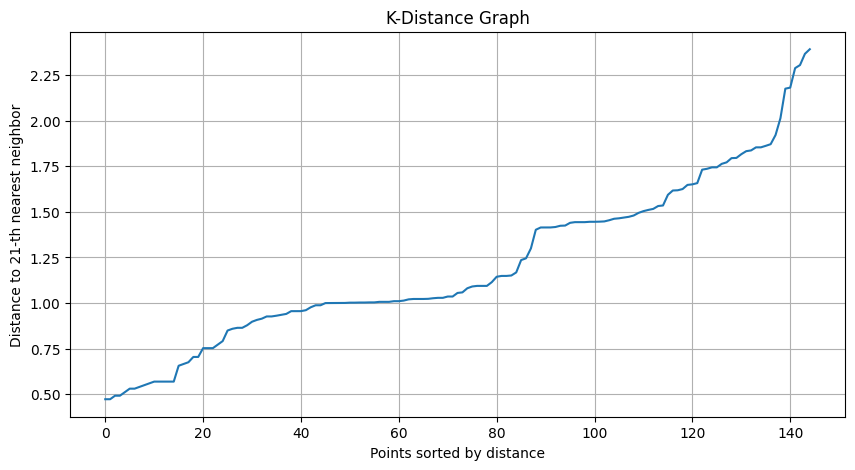

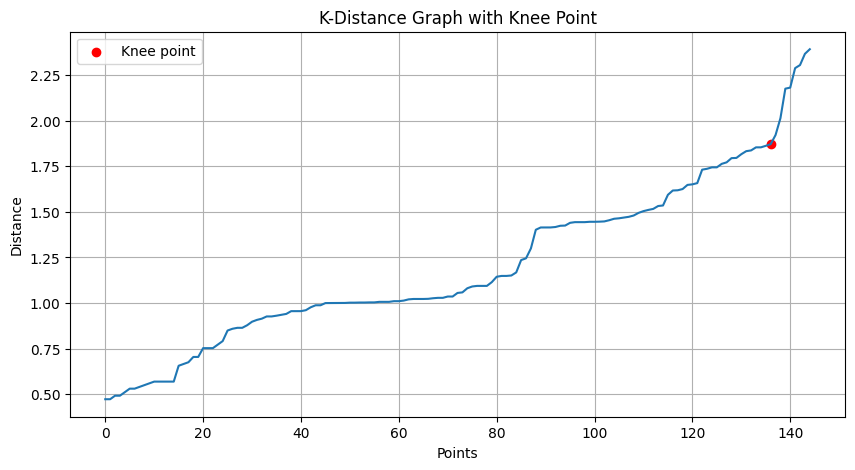

1.8708523133271056
eps: 1.4966818506616846, min_pts: 4, clusters: 1
eps: 1.4966818506616846, min_pts: 6, clusters: 1
eps: 1.683767081994395, min_pts: 4, clusters: 1
eps: 1.683767081994395, min_pts: 6, clusters: 1
eps: 1.8708523133271058, min_pts: 4, clusters: 1
eps: 1.8708523133271058, min_pts: 6, clusters: 1
eps: 2.0579375446598163, min_pts: 4, clusters: 1
eps: 2.0579375446598163, min_pts: 6, clusters: 1
eps: 2.2450227759925268, min_pts: 4, clusters: 1
eps: 2.2450227759925268, min_pts: 6, clusters: 1


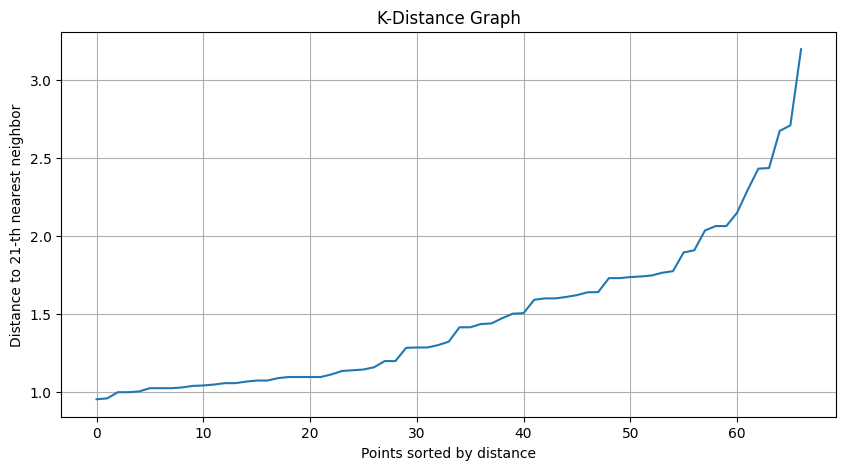

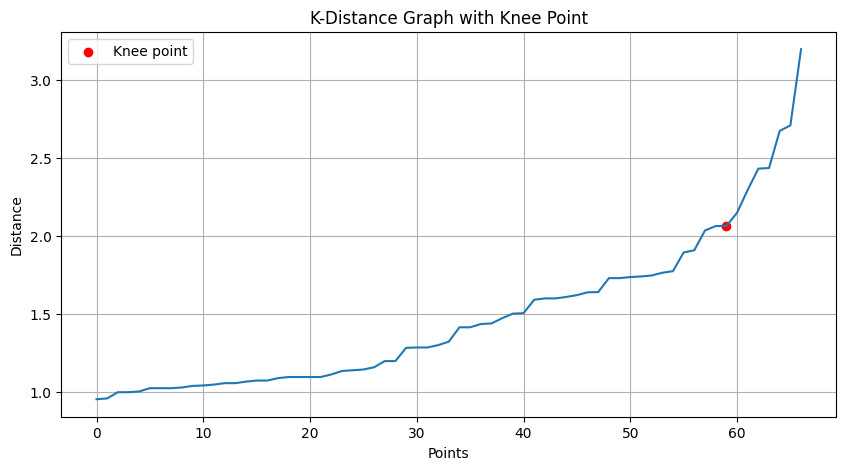

2.0659008248699586
eps: 1.652720659895967, min_pts: 4, clusters: 1
eps: 1.652720659895967, min_pts: 6, clusters: 1
eps: 1.8593107423829627, min_pts: 4, clusters: 1
eps: 1.8593107423829627, min_pts: 6, clusters: 1
eps: 2.0659008248699586, min_pts: 4, clusters: 1
eps: 2.0659008248699586, min_pts: 6, clusters: 1
eps: 2.2724909073569544, min_pts: 4, clusters: 1
eps: 2.2724909073569544, min_pts: 6, clusters: 1
eps: 2.47908098984395, min_pts: 4, clusters: 1
eps: 2.47908098984395, min_pts: 6, clusters: 1
Silhouette Score after Recursive DBSCAN refinement: 0.3283985031748593
Silhouette Score after Recursive DBSCAN refinement: 0.3283985031748593
Processing cluster 3 with 876 transactions
Adjusted thresholds for cluster 3: support=0.044805936073059355, confidence=0.38186813186813184, lift=1.3854477844162312
Processing cluster 4 with 272 transactions
Adjusted thresholds for cluster 4: support=0.051470588235294115, confidence=0.4615384615384616, lift=1.5655655655655658
Processing cluster 1 with 10

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


{3:                                           antecedents  \
2                       (edu_interaction_(6.0, 12.0])   
3                        (standard_of_living_index_3)   
4   (husband_occupation_3, edu_interaction_(6.0, 1...   
5   (husband_occupation_3, standard_of_living_inde...   
6   (edu_interaction_(6.0, 12.0], standard_of_livi...   
8             (age_children_interaction_(42.0, 87.0])   
10            (age_children_interaction_(42.0, 87.0])   
11  (edu_interaction_(6.0, 12.0], age_children_int...   
12  (edu_interaction_(6.0, 12.0], standard_of_livi...   
13  (age_children_interaction_(42.0, 87.0], standa...   
15  (age_children_interaction_(42.0, 87.0], standa...   
19  (husband_occupation_3, age_children_interactio...   
20  (edu_interaction_(6.0, 12.0], age_children_int...   
21  (edu_interaction_(12.0, 16.0], age_children_in...   
22  (standard_of_living_index_4, age_children_inte...   
26  (edu_interaction_(6.0, 12.0], husband_occupati...   
27  (husband_occupation_2, 

In [173]:
execute_pipeline(cmc_df, 'contraceptive_method', 'cmc_pipeline_results')